# Импорт библиотек

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import optuna

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from mlxtend.regressor import StackingCVRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import logging
import warnings

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Загрузка данных

In [111]:
train_data = pd.read_csv('data/train.csv', index_col=0)
test_data = pd.read_csv('data/test.csv', index_col=0)

# EDA

Примеры из набора данных приведены ниже

In [112]:
train_data.sample(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
22            45       RM         57.0     7449   Pave  Grvl      Reg   
1188          20       RL         89.0    12461   Pave   NaN      Reg   
1067          60       RL         59.0     7837   Pave   NaN      IR1   
738           60       RL         72.0    10463   Pave   NaN      IR1   
117           20       RL          NaN    11616   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
Id                                    ...                                      
22           Bnk    AllPub    Inside  ...        0    NaN  GdPrv         NaN   
1188         Lvl    AllPub    Corner  ...        0    NaN  GdPrv         NaN   
1067         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
738          HLS    AllPub   CulDSac  ...        0    NaN    NaN         NaN   
117          Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                               
22         0      6    2007        WD         Normal     139400  
1188       0      7    2006        WD         Normal     262000  
1067       0      5    2009        WD         Normal     178000  
738        0      6    2006        WD         Normal     239900  
117        0      9    2009        WD         Normal     139000  

[5 rows x 80 columns]

In [113]:
train_data.shape

(1460, 80)

Размер набора данных 1460 строк и 80 столбцов. Из 80 признаков один является целевой переменной (SalePrice), которую модель должна предсказать. Соответственно, есть 79 признаков, которые могут использоваться для отбора признаков и инженерии признаков

## Анализ пропущенных значений

In [114]:
def get_missing_stats(df):
    total = df.isnull().sum()
    total = total[total > 0]
    percent = (total / len(df) * 100).round(2)
    return pd.DataFrame({'Total': total, 'Percent': percent})

In [115]:
miss_train = get_missing_stats(train_data)
miss_test = get_missing_stats(test_data)

missing_data_df = pd.concat([miss_train, miss_test], axis=1, keys=['Train', 'Test']).fillna(0).astype({'Train': {'Total': int}, 'Test': {'Total': int}})
missing_data_df = missing_data_df.sort_values(('Train', 'Total'), ascending=False)

missing_data_df.style.background_gradient('rocket_r')

На данном этапе проведён первичный анализ пропусков в тренировочном и тестовом датасетах. Таблица выше показывает количество пропущенных значений (`Total`) и их процентное соотношение (`Percent`) для каждой переменной.  

Из анализа можно выделить несколько важных моментов:

1. **Признаки с минимальным количеством пропусков**  
   - `PoolQC`, `MiscFeature`, `Alley`, `Fence` содержат значительное количество пропусков (от ~80% до >99%), что связано с особенностями данных (например, отсутствие бассейна или забора является валидным состоянием).  
   - `MasVnrType`, `FireplaceQu` имеют около 50–60% заполненных значений, что требует особого подхода при обработке.

2. **Признаки с редкими пропусками**  
   - `LotFrontage` имеет пропуски в ~16–18% случаев, что может потребовать интерполяции или замены медианным значением.  
   - `Garage*` и `Bsmt*` признаки имеют небольшое количество пропусков (около 5% и менее), что может быть связано с отсутствием соответствующих объектов (гараж, подвал).

3. **Признаки с почти полным отсутствием данных в тренировочном наборе**  
   - `Electrical`, `MSZoning`, `Utilities`, `Exterior1st/2nd`, `BsmtFinSF*`, `KitchenQual`, `Functional`, `GarageCars/Area`, `SaleType` имеют 0% заполнения в тренировочном наборе, но частично присутствуют в тестовом.  
   - Эти признаки требуют внимательного рассмотрения при предобработке для предотвращения утечки данных и ошибок при обучении модели.

В дальнейшем, на этапе предобработки данных, мы детально рассмотрим стратегии заполнения пропусков для каждой группы признаков. В частности, будет определено, какие значения заменяются на медиану, моду или специальный маркер отсутствия объекта (`None`/`NA`), а также какие признаки могут быть исключены из модели из-за чрезмерного количества пропусков.

## Числовые столбцы в наборе данных

In [116]:
train_data.select_dtypes(exclude=['object']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [117]:
len(train_data.select_dtypes(exclude='object').columns)

37

Выше приведённые данные указывают на наличие приблизительно 37 числовых столбцов, включая целевой SalePrice. Такие столбцы тоже могут быть интерпретированы как категориальные данные. У них имеются следующие общие характеристики:

In [118]:
train_data.select_dtypes(exclude=['object']).describe().round(2).transpose()

count       mean       std      min        25%       50%  \
MSSubClass     1460.0      56.90     42.30     20.0      20.00      50.0   
LotFrontage    1201.0      70.05     24.28     21.0      59.00      69.0   
LotArea        1460.0   10516.83   9981.26   1300.0    7553.50    9478.5   
OverallQual    1460.0       6.10      1.38      1.0       5.00       6.0   
OverallCond    1460.0       5.58      1.11      1.0       5.00       5.0   
YearBuilt      1460.0    1971.27     30.20   1872.0    1954.00    1973.0   
YearRemodAdd   1460.0    1984.87     20.65   1950.0    1967.00    1994.0   
MasVnrArea     1452.0     103.69    181.07      0.0       0.00       0.0   
BsmtFinSF1     1460.0     443.64    456.10      0.0       0.00     383.5   
BsmtFinSF2     1460.0      46.55    161.32      0.0       0.00       0.0   
BsmtUnfSF      1460.0     567.24    441.87      0.0     223.00     477.5   
TotalBsmtSF    1460.0    1057.43    438.71      0.0     795.75     991.5   
1stFlrSF       1460.0    1162.63    386.59    334.0     882.00    1087.0   
2ndFlrSF       1460.0     346.99    436.53      0.0       0.00       0.0   
LowQualFinSF   1460.0       5.84     48.62      0.0       0.00       0.0   
GrLivArea      1460.0    1515.46    525.48    334.0    1129.50    1464.0   
BsmtFullBath   1460.0       0.43      0.52      0.0       0.00       0.0   
BsmtHalfBath   1460.0       0.06      0.24      0.0       0.00       0.0   
FullBath       1460.0       1.57      0.55      0.0       1.00       2.0   
HalfBath       1460.0       0.38      0.50      0.0       0.00       0.0   
BedroomAbvGr   1460.0       2.87      0.82      0.0       2.00       3.0   
KitchenAbvGr   1460.0       1.05      0.22      0.0       1.00       1.0   
TotRmsAbvGrd   1460.0       6.52      1.63      2.0       5.00       6.0   
Fireplaces     1460.0       0.61      0.64      0.0       0.00       1.0   
GarageYrBlt    1379.0    1978.51     24.69   1900.0    1961.00    1980.0   
GarageCars     1460.0       1.77      0.75      0.0       1.00       2.0   
GarageArea     1460.0     472.98    213.80      0.0     334.50     480.0   
WoodDeckSF     1460.0      94.24    125.34      0.0       0.00       0.0   
OpenPorchSF    1460.0      46.66     66.26      0.0       0.00      25.0   
EnclosedPorch  1460.0      21.95     61.12      0.0       0.00       0.0   
3SsnPorch      1460.0       3.41     29.32      0.0       0.00       0.0   
ScreenPorch    1460.0      15.06     55.76      0.0       0.00       0.0   
PoolArea       1460.0       2.76     40.18      0.0       0.00       0.0   
MiscVal        1460.0      43.49    496.12      0.0       0.00       0.0   
MoSold         1460.0       6.32      2.70      1.0       5.00       6.0   
YrSold         1460.0    2007.82      1.33   2006.0    2007.00    2008.0   
SalePrice      1460.0  180921.20  79442.50  34900.0  129975.00  163000.0   

                     75%       max  
MSSubClass         70.00     190.0  
LotFrontage        80.00     313.0  
LotArea         11601.50  215245.0  
OverallQual         7.00      10.0  
OverallCond         6.00       9.0  
YearBuilt        2000.00    2010.0  
YearRemodAdd     2004.00    2010.0  
MasVnrArea        166.00    1600.0  
BsmtFinSF1        712.25    5644.0  
BsmtFinSF2          0.00    1474.0  
BsmtUnfSF         808.00    2336.0  
TotalBsmtSF      1298.25    6110.0  
1stFlrSF         1391.25    4692.0  
2ndFlrSF          728.00    2065.0  
LowQualFinSF        0.00     572.0  
GrLivArea        1776.75    5642.0  
BsmtFullBath        1.00       3.0  
BsmtHalfBath        0.00       2.0  
FullBath            2.00       3.0  
HalfBath            1.00       2.0  
BedroomAbvGr        3.00       8.0  
KitchenAbvGr        1.00       3.0  
TotRmsAbvGrd        7.00      14.0  
Fireplaces          1.00       3.0  
GarageYrBlt      2002.00    2010.0  
GarageCars          2.00       4.0  
GarageArea        576.00    1418.0  
WoodDeckSF        168.00     857.0  
OpenPorchSF        68.00     547.0  
EnclosedPorch    

## Категориальные столбцы в наборе данных

In [119]:
train_data.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [120]:
len(train_data.select_dtypes(include=['object']).columns)

43

Выше приведённые данные указывают на наличие 43 категориальных столбца. У них имеются следующие общие характеристики:

In [121]:
train_data.select_dtypes(include=['object']).describe().transpose()

count unique      top  freq
MSZoning       1460      5       RL  1151
Street         1460      2     Pave  1454
Alley            91      2     Grvl    50
LotShape       1460      4      Reg   925
LandContour    1460      4      Lvl  1311
Utilities      1460      2   AllPub  1459
LotConfig      1460      5   Inside  1052
LandSlope      1460      3      Gtl  1382
Neighborhood   1460     25    NAmes   225
Condition1     1460      9     Norm  1260
Condition2     1460      8     Norm  1445
BldgType       1460      5     1Fam  1220
HouseStyle     1460      8   1Story   726
RoofStyle      1460      6    Gable  1141
RoofMatl       1460      8  CompShg  1434
Exterior1st    1460     15  VinylSd   515
Exterior2nd    1460     16  VinylSd   504
MasVnrType      588      3  BrkFace   445
ExterQual      1460      4       TA   906
ExterCond      1460      5       TA  1282
Foundation     1460      6    PConc   647
BsmtQual       1423      4       TA   649
BsmtCond       1423      4       TA  1311
BsmtExposure   1422      4       No   953
BsmtFinType1   1423      6      Unf   430
BsmtFinType2   1422      6      Unf  1256
Heating        1460      6     GasA  1428
HeatingQC      1460      5       Ex   741
CentralAir     1460      2        Y  1365
Electrical     1459      5    SBrkr  1334
KitchenQual    1460      4       TA   735
Functional     1460      7      Typ  1360
FireplaceQu     770      5       Gd   380
GarageType     1379      6   Attchd   870
GarageFinish   1379      3      Unf   605
GarageQual     1379      5       TA  1311
GarageCond     1379      5       TA  1326
PavedDrive     1460      3        Y  1340
PoolQC            7      3       Gd     3
Fence           281      4    MnPrv   157
MiscFeature      54      4     Shed    49
SaleType       1460      9       WD  1267
SaleCondition  1460      6   Normal  1198

## Анализ числовых столбцов

### Скошенность целевого столбца

<Figure size 640x480 with 0 Axes>

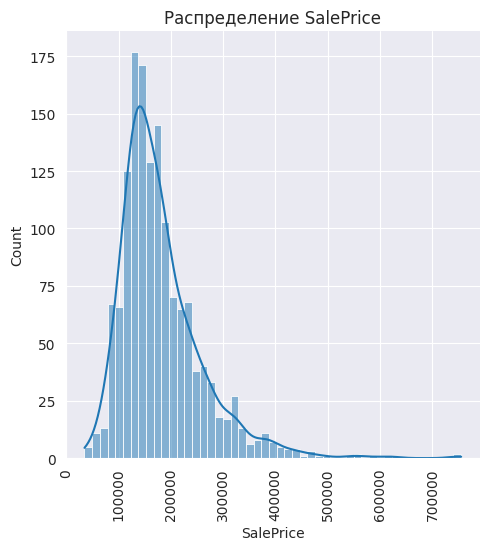

In [122]:
target = train_data['SalePrice']
plt.figure()
sns.displot(target,kde=True)
plt.title("Распределение SalePrice")
plt.xticks(rotation=90)
plt.show()

<Figure size 640x480 with 0 Axes>

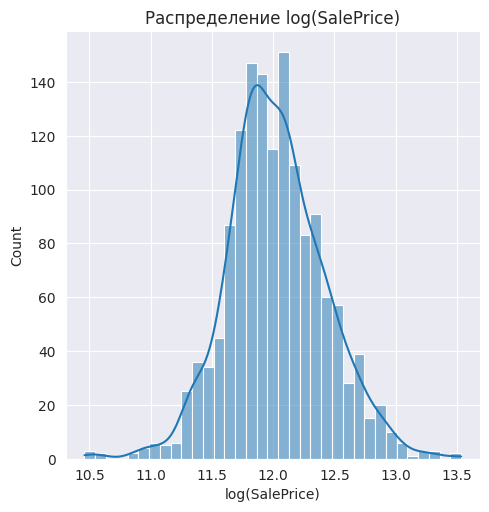

In [123]:
plt.figure()
sns.displot(np.log(target),kde=True)
plt.title("Распределение log(SalePrice)")
plt.xlabel('log(SalePrice)')
plt.show()

Распределение SalePrice скошено вправо из-за наличия редких, но очень дорогих домов, которые создают длинный правый хвост, несмотря на то, что основная масса данных сосредоточена слева. После логарифмирования распределение становится более симметричным и приближается к нормальному распределению, что улучшает условия для построения регрессионных моделей и повышает их точность.

### Распределения числовых признаков

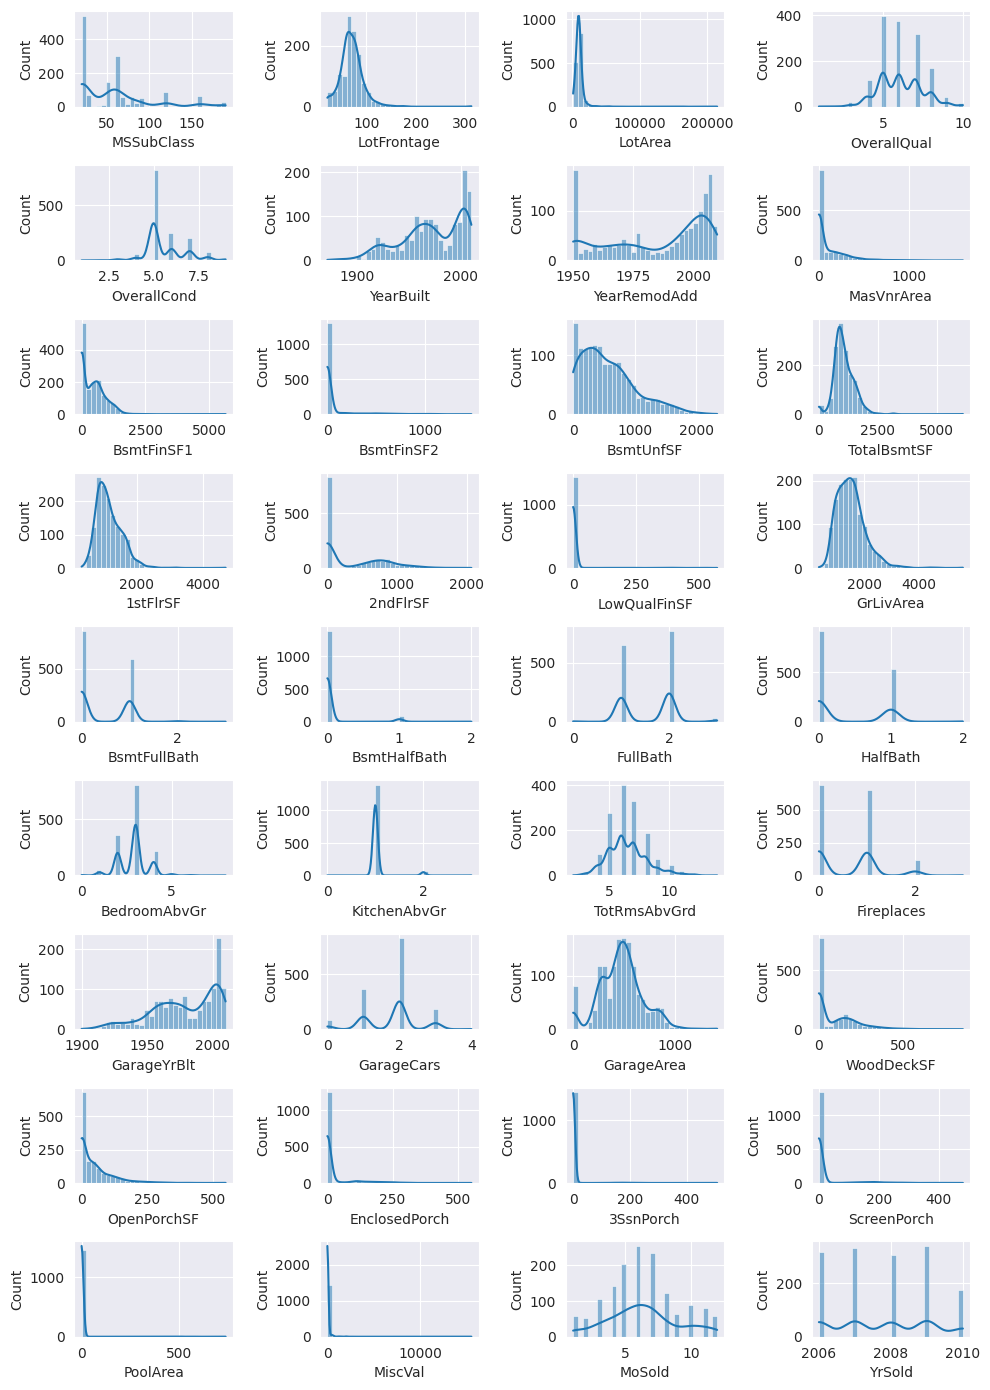

In [124]:
num_cols = train_data.select_dtypes(exclude='object').drop('SalePrice', axis=1).copy()

fig = plt.figure(figsize=(10,14))
for i in range(len(num_cols.columns)):
    ax = fig.add_subplot(9,4,i+1)
    sns.histplot(num_cols.iloc[:, i].dropna(), ax=ax, bins=30, kde=True)
    plt.xlabel(num_cols.columns[i])

plt.tight_layout()
plt.show()

На гистограммах показаны распределения всех числовых признаков датасета. Рассмотрим ключевые особенности.

#### Скошенность распределений
Многие признаки имеют выраженную **правостороннюю скошенность** с длинными хвостами:  
- `LotFrontage`, `LotArea`, `GrLivArea`, `GarageArea`, `OpenPorchSF`, `BsmtFinSF1`.  
Это указывает на наличие объектов с крайне большими значениями (например, дома с большой жилой или земельной площадью).  
Для снижения влияния редких экстремальных объектов возможно применение **логарифмического преобразования**.

#### Симметричные и близкие к нормальным распределения
Некоторые признаки демонстрируют более сбалансированное распределение:  
- `OverallQual`, `OverallCond`, `YearBuilt`, `YearRemodAdd`.  
Они не требуют специальных преобразований и подходят для использования в моделях в исходном виде.

#### Дискретные признаки
К ряду признаков относятся целочисленные дискретные величины с ограниченным числом значений:  
- `BsmtFullBath`, `HalfBath`, `Fireplaces`, `GarageCars`, `KitchenAbvGr`, `MoSold`, `YrSold`.  
Их распределения имеют вид отдельных пиков. Масштабирование или лог-преобразования для них нецелесообразны, так как они фактически ближе к **категориальным признакам**, даже если представлены числами.

### Анализ выбросов

Визуализация помогает выявлять возможные выбросы в данных. Например:

- В одномерном анализе можно использовать box plot, где выбросами считаются значения за пределами 1.5-3 межквартильного размаха. Если данные сильно скошены, полезно предварительно их трансформировать.

- При анализе взаимосвязей между двумя признаками (scatter plot) выбросы — это точки с необычными значениями одного признака при сходных значениях другого. 

#### Одномерный анализ

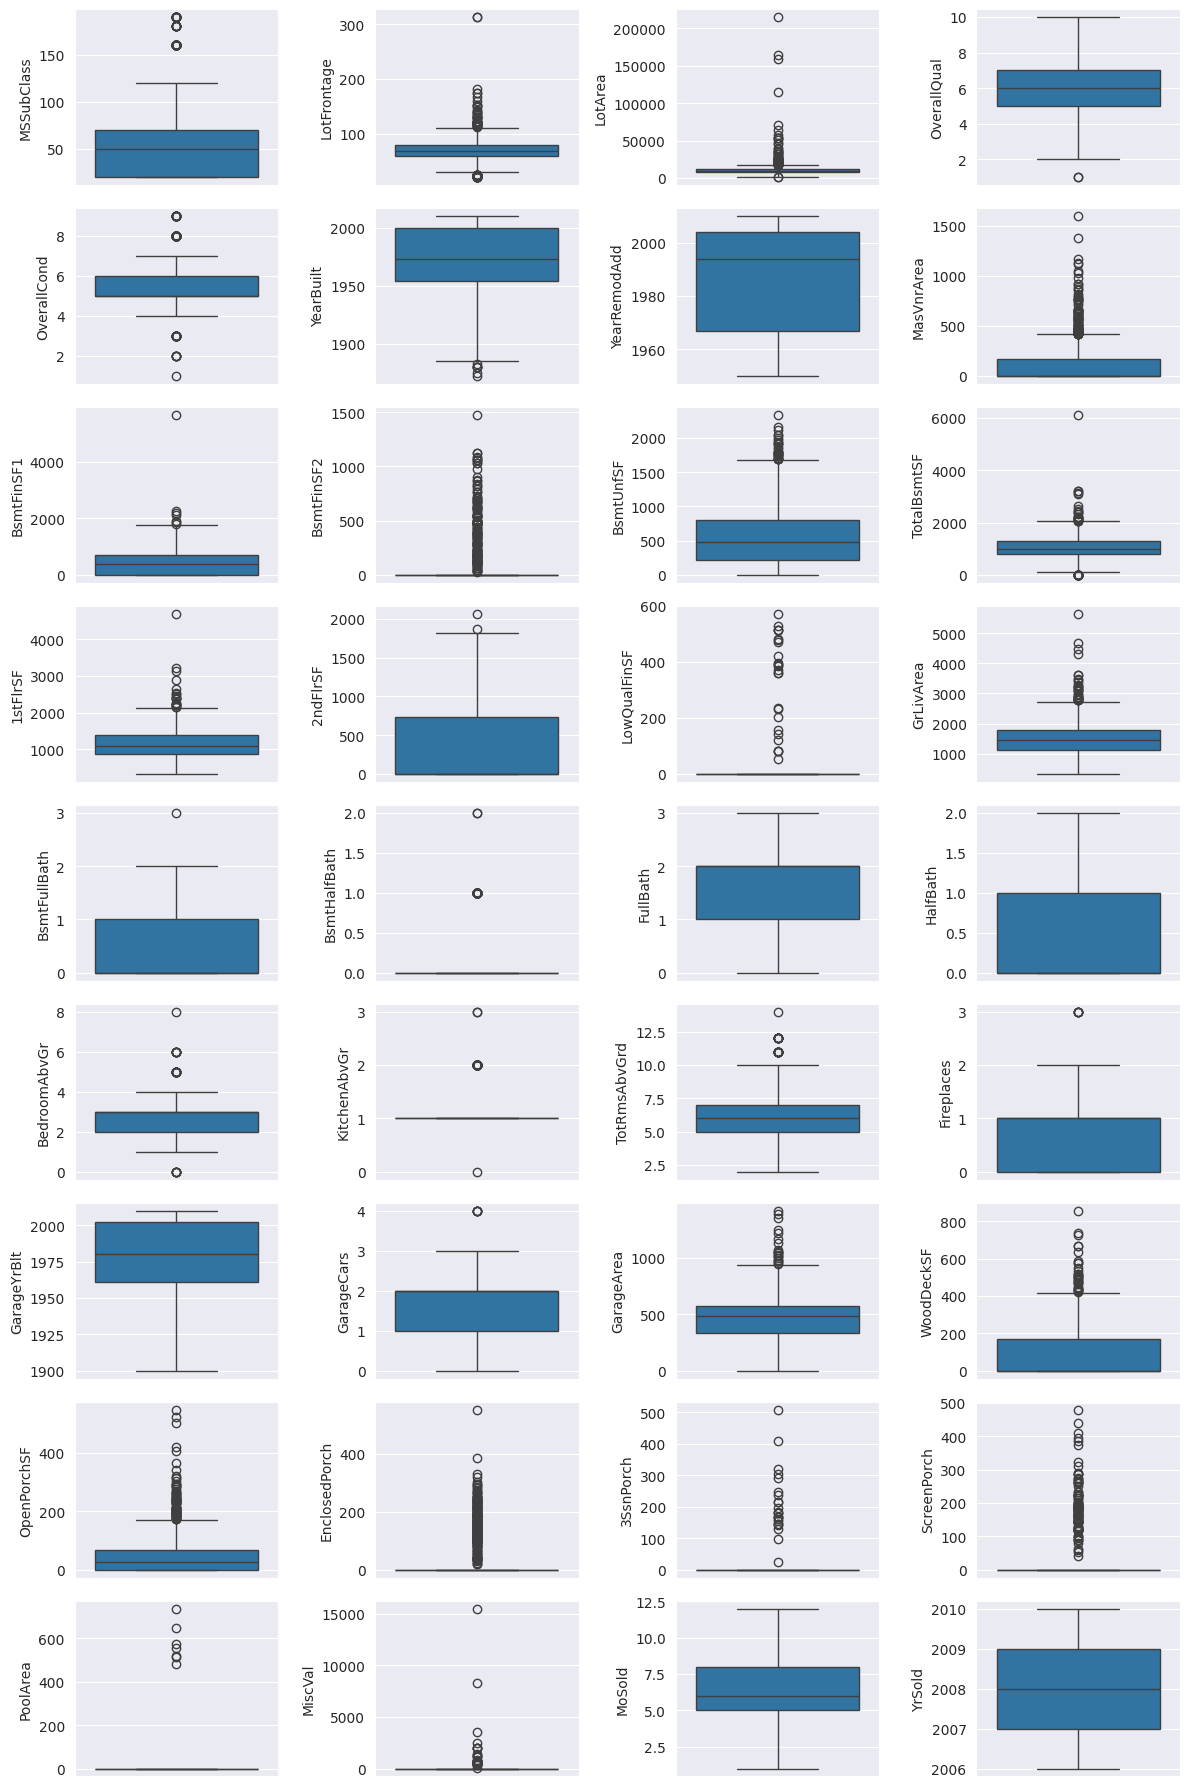

In [125]:
fig = plt.figure(figsize=(12, 18))

for i in range(len(num_cols.columns)):
    fig.add_subplot(9, 4, i+1)
    sns.boxplot(y=num_cols.iloc[:,i])

plt.tight_layout()
plt.show()


#### Двумерный анализ

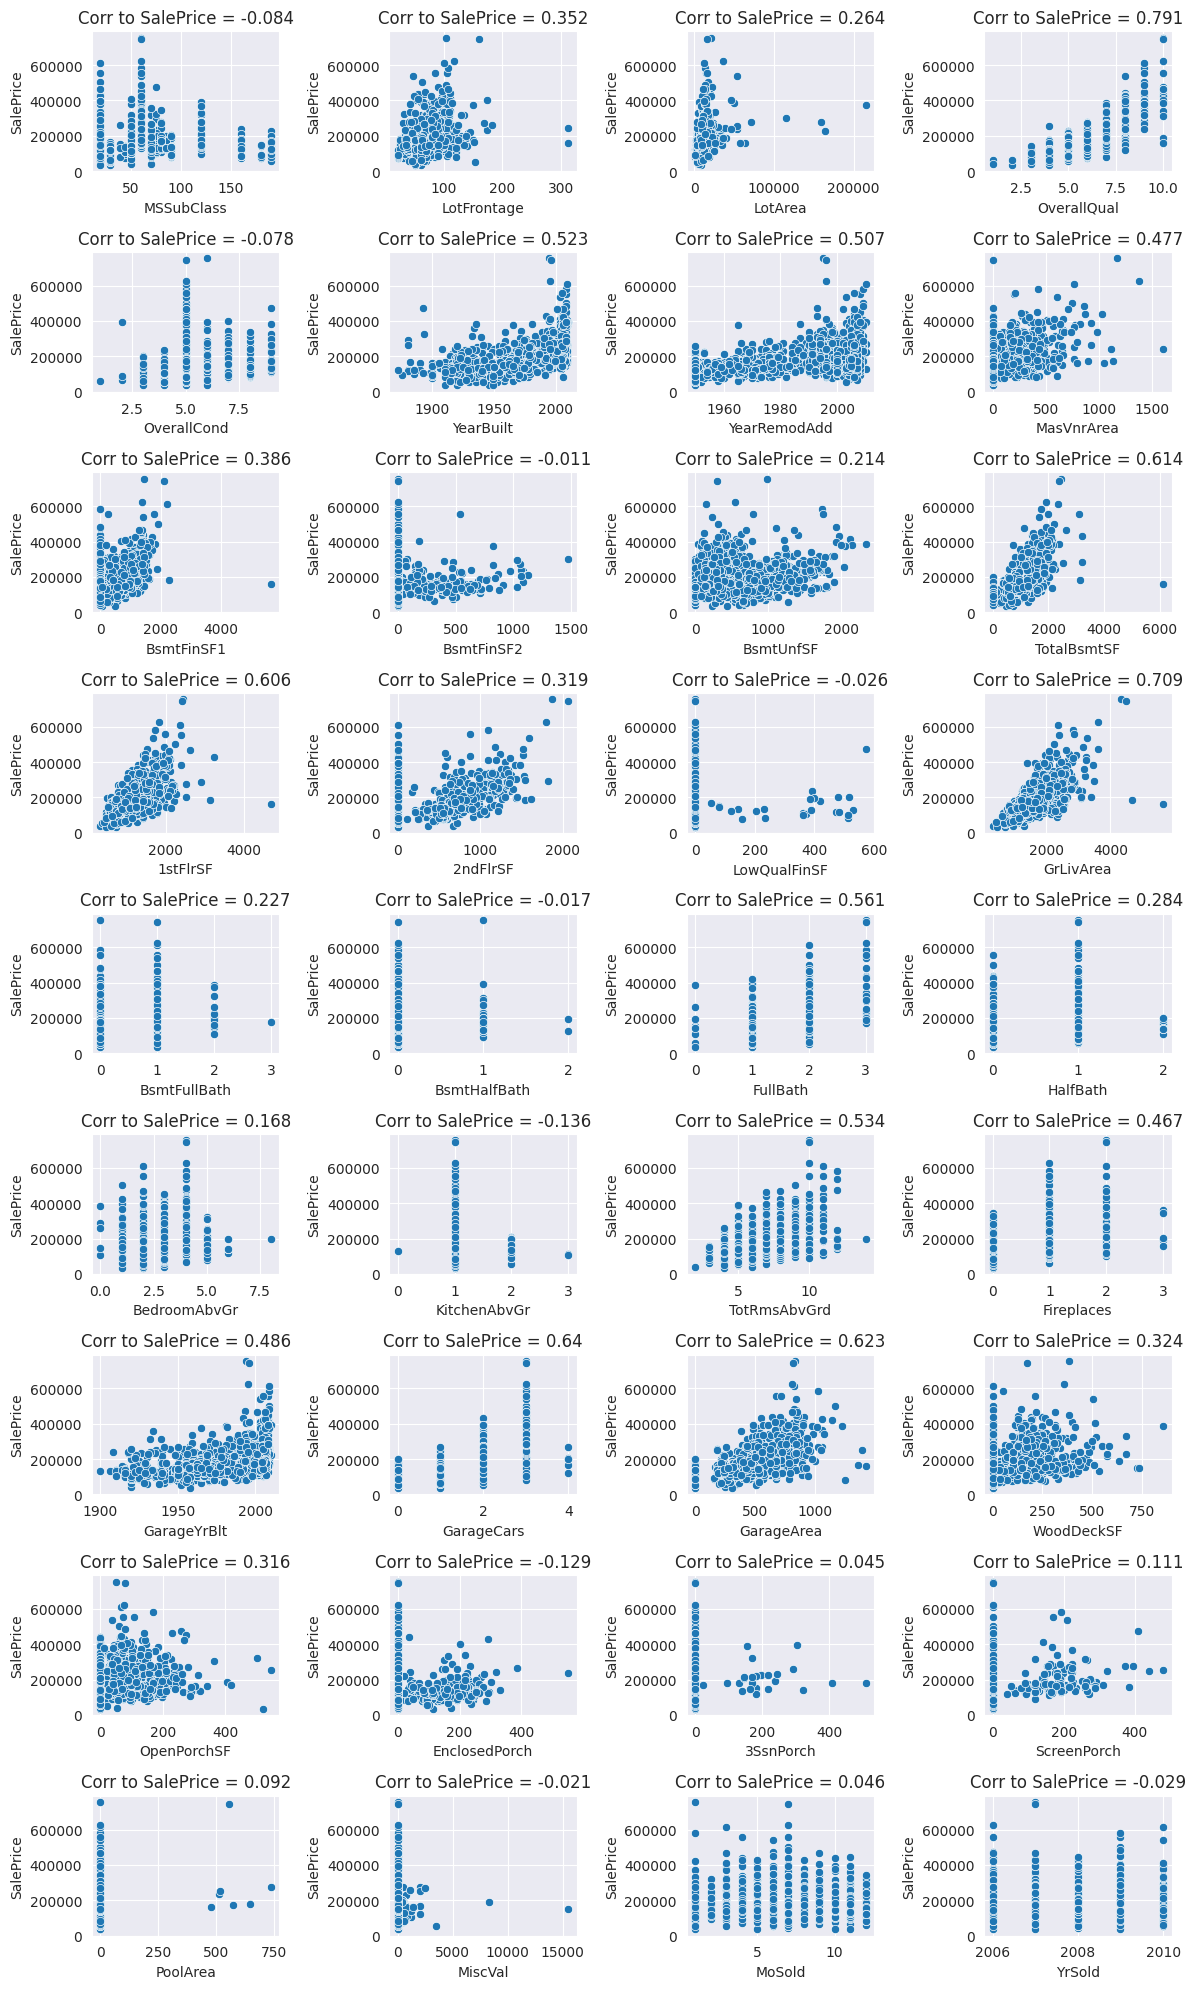

In [126]:
correlation = train_data.corr(numeric_only=True)
corr_price = correlation['SalePrice']

f = plt.figure(figsize=(12,20))

for i in range(len(num_cols.columns)):
    f.add_subplot(9, 4, i+1)
    sns.scatterplot(x=num_cols.iloc[:,i], y=target)
    plt.title('Corr to SalePrice = {}'.format(np.around(corr_price.iloc[i], decimals=3)))
    
plt.tight_layout()
plt.show()

Выбросы в данных могут искажать статистические характеристики признаков, влиять на корреляции и снижать качество моделей. Для их выявления был проведён **одномерный** и **двумерный** анализ:

#### Одномерный анализ (Box Plot)
- Для каждого числового признака построены box plot.  
- Визуально выбросами считаются значения, выходящие за пределы 1.5–3 межквартильных размахов (IQR).   

#### Двумерный анализ (Scatter Plot с SalePrice)
- Для оценки выбросов относительно целевой переменной использовались scatter plot.  
- Выбросами считались точки, обладающие аномально высокими/низкими значениями признаков при условии, что для аналогичных значений других объектов наблюдается значительно иное распределение цены.  
- Такой подход позволяет выявить структурные выбросы, например, слишком большую жилую площадь при низкой цене.

---

#### Выявленные выбросы

- **LotFrontage** — значения выше ~200.  
- **LotArea** — значения выше ~100000.  
- **BsmtFinSF1** — значения выше ~4000.  
- **TotalBsmtSF** — значения выше ~6000.  
- **1stFlrSF** — значения выше ~4000.  
- **GrLivArea** — значения выше ~4000 при *SalePrice* < 300000 (аномально большие площади при относительно низкой цене).  
- **LowQualFinSF** — значения выше ~550.  

---

### Анализ корреляций

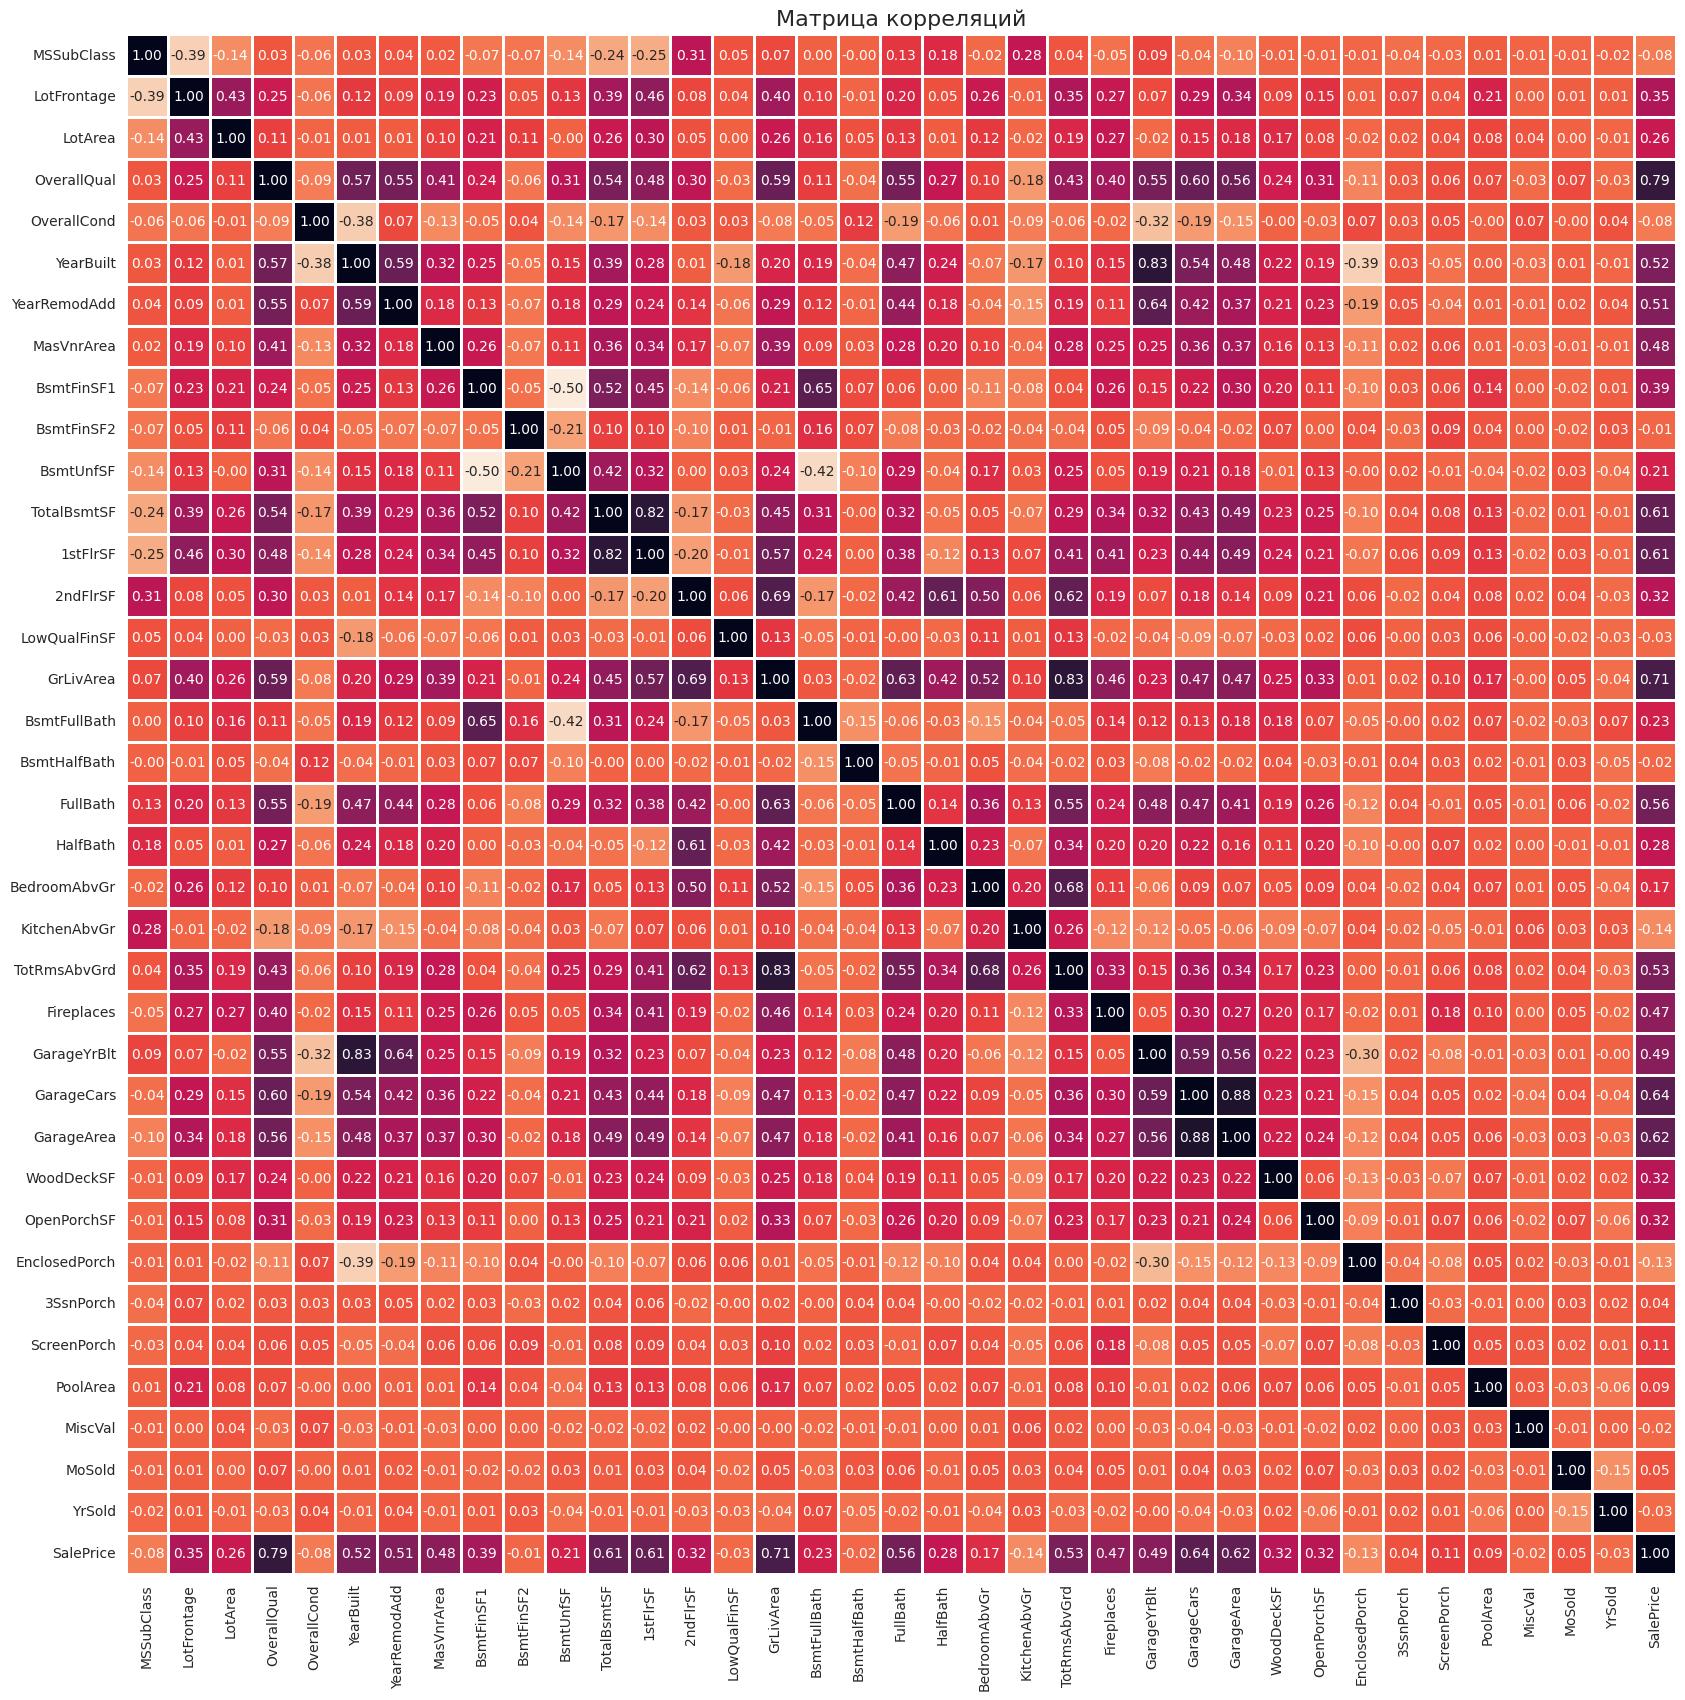

In [127]:
plt.figure(figsize=(20,20))
correlation = train_data.corr(numeric_only=True)
sns.heatmap(correlation, linewidth=1, cmap='rocket_r', annot=True, fmt='.2f', cbar=False)
plt.title("Матрица корреляций", size=16)
plt.show()

Матрица корреляций показывает как признаки, связанные с `SalePrice`, так и признаки с высокой взаимной корреляцией (мультиколлинеарностью).  

---

#### Сильные корреляции с `SalePrice`

Наиболее значимые положительные зависимости:
- **OverallQual** (качество дома) — ~0.79  
- **GrLivArea** (жилая площадь) — ~0.71  
- **GarageCars** и **GarageArea** (размер/вместимость гаража) — ~0.64 / ~0.62  
- **TotalBsmtSF** (общая площадь подвала) — ~0.61  
- **1stFlrSF** (площадь 1-го этажа) — ~0.60  
- **YearBuilt** и **YearRemodAdd** (год постройки и реконструкции) — ~0.52 / ~0.51  

Наиболее выраженная отрицательная зависимость:
- **OverallCond** (общее состояние дома) — около -0.42  

---

#### Высокая мультиколлинеарность

- **GarageCars** и **GarageArea** — ~0.88  
- **GrLivArea** и **TotRmsAbvGrd** — ~0.83  
- **TotalBsmtSF** и **1stFlrSF** — ~0.82  
- **YearBuilt** и **GarageYrBlt** — ~0.83  

При построении моделей стоит исключить один из сильно коррелирующих признаков.

---

#### Признаки для исключения

На основе анализа scatter plot и матрицы корреляций рекомендуется удалить:  

- **GarageArea** — сильно коррелирует с GarageCars (0.88).  
- **GarageYrBlt** — высокая корреляция с YearBuilt (0.83).  
- **TotRmsAbvGrd** — высокая корреляция с GrLivArea (0.83).  
- **1stFlrSF** — высокая корреляция с TotalBsmtSF (0.82).  
- Признаки с низкой корреляцией с ценой и неявной нелинейной связью:  
  - MSSubClass  
  - MoSold  
  - YrSold  
  - MiscVal  
  - BsmtFinSF2  
  - BsmtUnfSF  
  - LowQualFinSF  
  - 3SsnPorch  
  - OverallCond  

---

## Анализ категориальных столбцов

In [128]:
cat_cols = train_data.select_dtypes(include=['object'])

### Распределения категориальных признаков

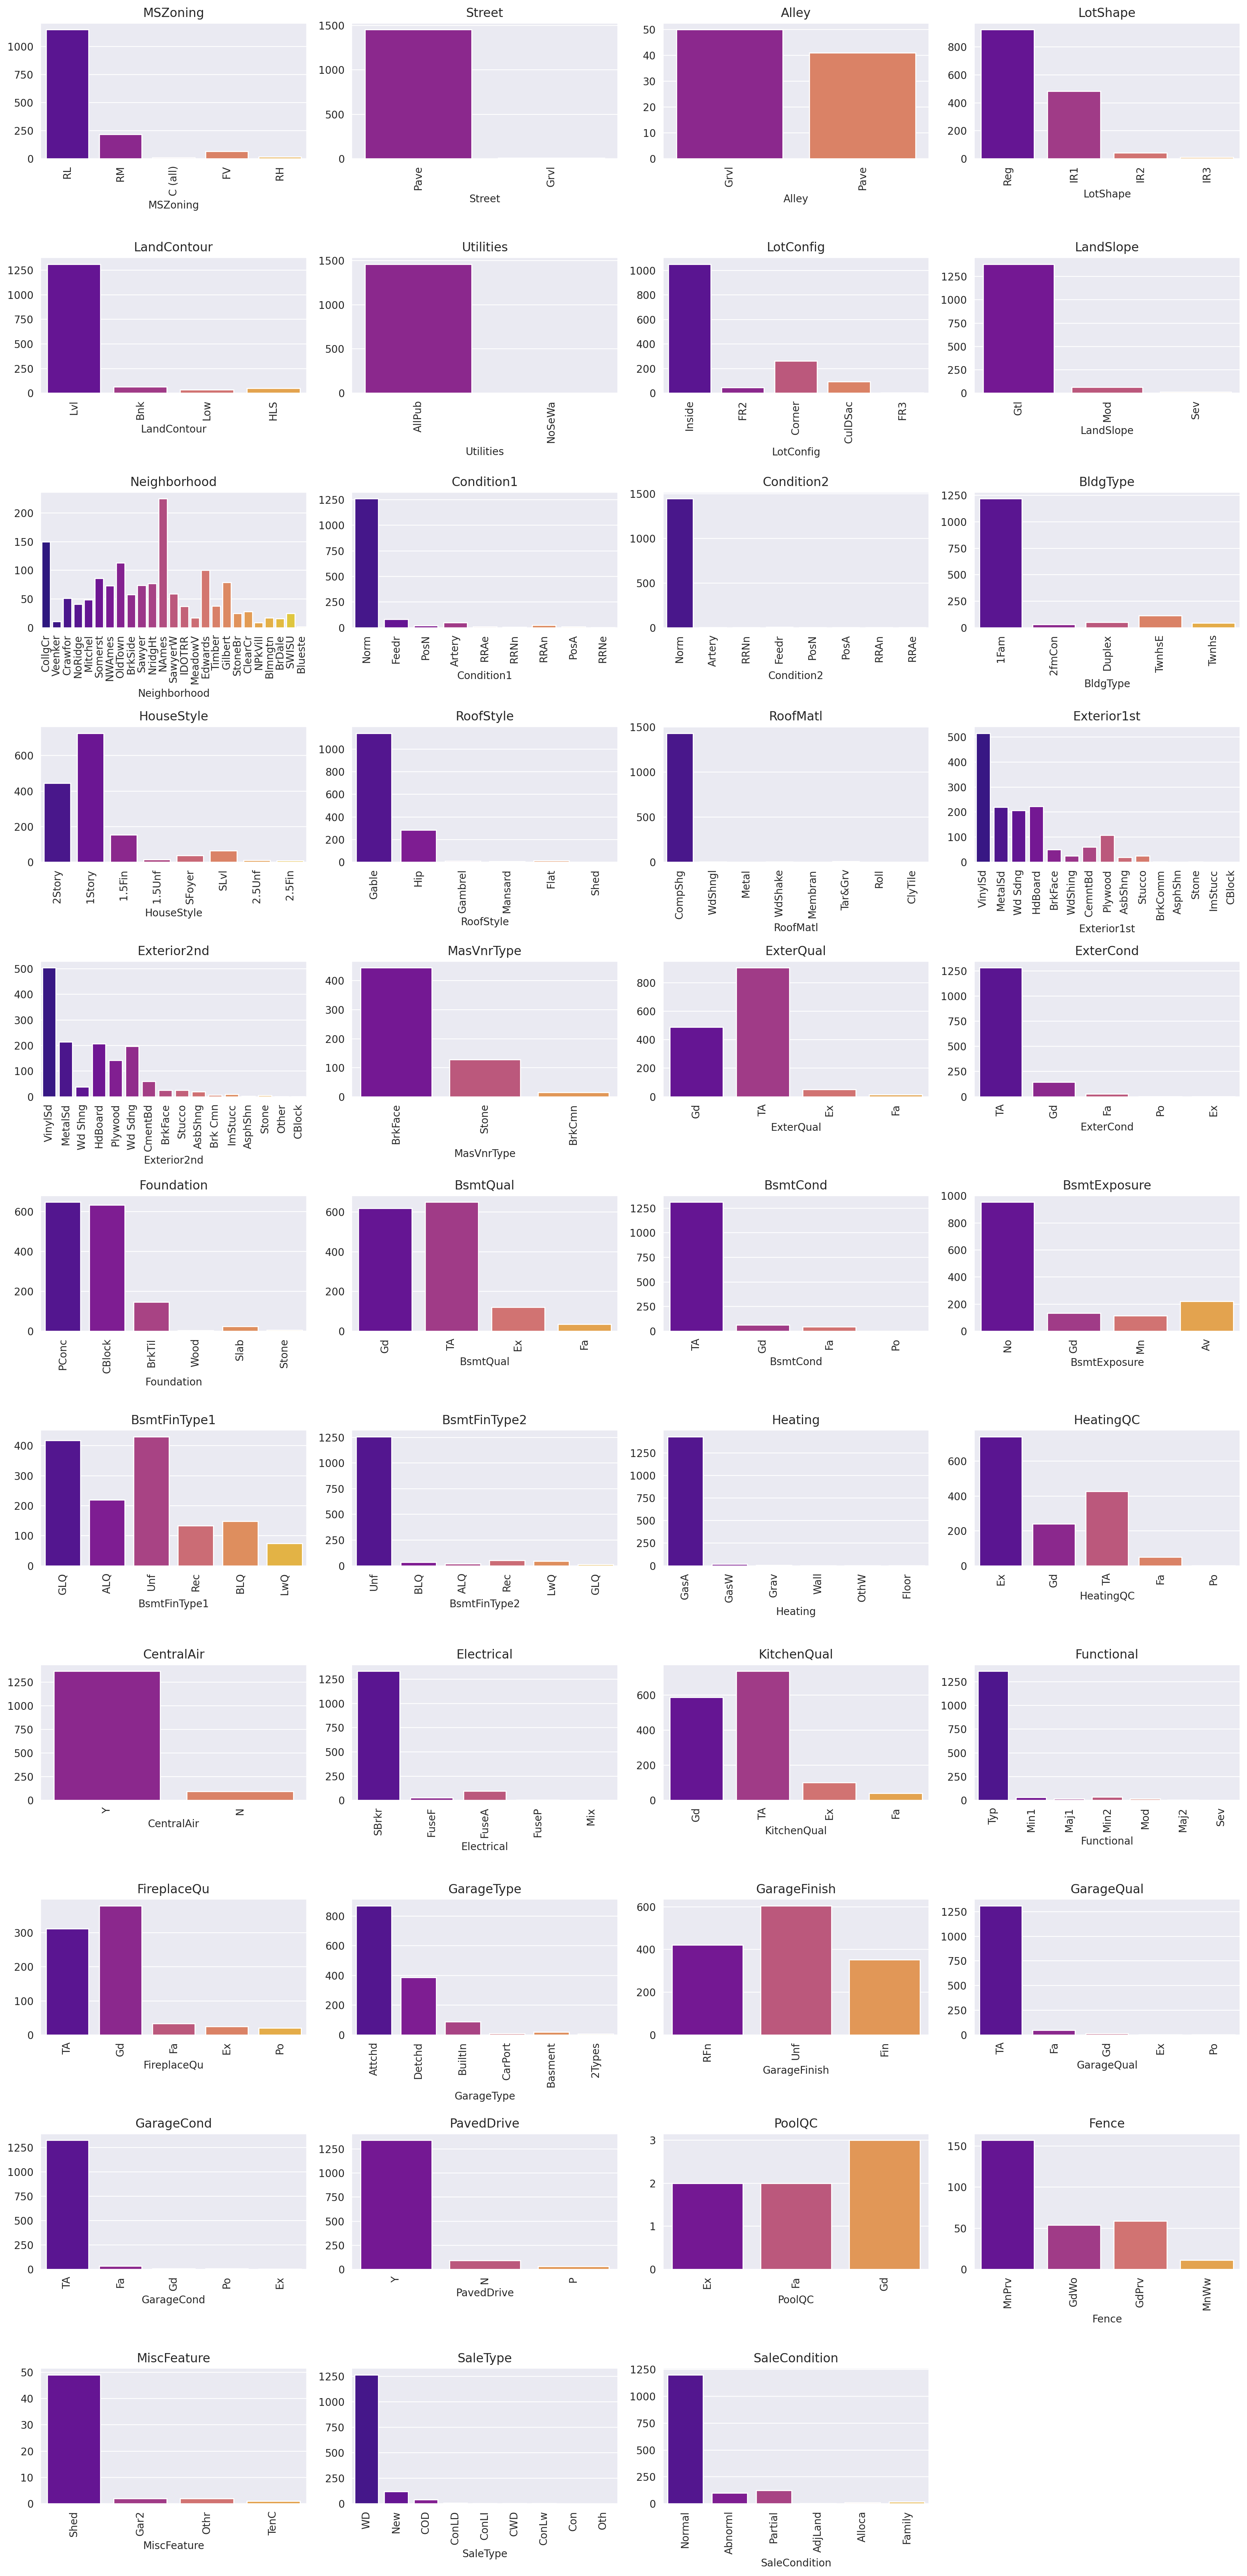

In [129]:
plt.figure(figsize=(17, 35), dpi=200)

for i, col in enumerate(cat_cols.columns):
    ax = plt.subplot(11, 4, i + 1)
    sns.countplot(x=col, data=cat_cols, palette='plasma', hue=col)
    plt.xticks(rotation=90)
    plt.ylabel('')
    plt.title(col)
    if ax.get_legend() is not None:
        ax.get_legend().remove()

plt.tight_layout()
plt.show()


На графиках представлены распределения категориальных признаков датасета. Рассмотрим ключевые особенности.

#### Доминирующие классы
Для большинства категориальных переменных наблюдается выраженная **дисбалансировка классов**, когда один или несколько значений встречаются значительно чаще остальных:
- `MSZoning` — доминирует категория `RL` (Residential Low Density).
- `Street` — почти все объекты имеют тип `Pave`.
- `Utilities` — фактически все объекты принадлежат к классу `AllPub`.
- `CentralAir` — подавляющее большинство домов оборудованы центральным кондиционированием (`Y`).
- `PavedDrive` — преобладает категория `Y` (асфальтированный подъезд).

#### Признаки с умеренным разнообразием категорий
Некоторые признаки содержат несколько относительно равномерно распределённых значений:
- `Neighborhood` — значения распределены более равномерно, но выделяется несколько районов-лидеров (например, `NAmes`, `CollgCr`, `OldTown`).
- `LotConfig` — есть значимые группы (`Inside`, `Corner`), а редкие классы (`FR2`, `FR3`) представлены небольшим количеством объектов.
- `GarageFinish` — присутствует три значимых категории (`Fin`, `RFn`, `Unf`) без явного доминирования одной из них.
- `Condition1/2` — в основном представлены нормальные условия (`Norm`), но встречаются и редкие состояния (`Artery`, `RRAn`, `PosN` и др.), которые могут быть объединены.


#### Редкие категории
В ряде признаков встречаются значения с крайне низкой частотой:
- `RoofMatl` — почти все дома с материалом `CompShg`, остальные категории крайне редкие.
- `MiscFeature` — кроме `Shed`, остальные признаки встречаются крайне редко (`TenC`, `Othr`).
- `PoolQC`, `Alley`, `Fence` — большинство объектов имеют отсутствующие или маргинальные значения.
- `Condition2`, `Exterior2nd`, `Heating` — редкие категории могут быть объединены в общую группу (`Other`).

Редкие категории стоит обработать отдельно: либо объединить, либо использовать бининг.

#### Качественные признаки (Ordinal)
Некоторые переменные отражают **качество или состояние** объекта, что задаёт их упорядоченность:
- `ExterQual`, `ExterCond`, `BsmtQual`, `BsmtCond`, `HeatingQC`, `KitchenQual`, `FireplaceQu`, `GarageQual`, `GarageCond`.  
Для этих признаков целесообразно использовать **Ordinal Encoding**, сохранив порядок значений (`Ex > Gd > TA > Fa > Po`).


### Анализ выбросов

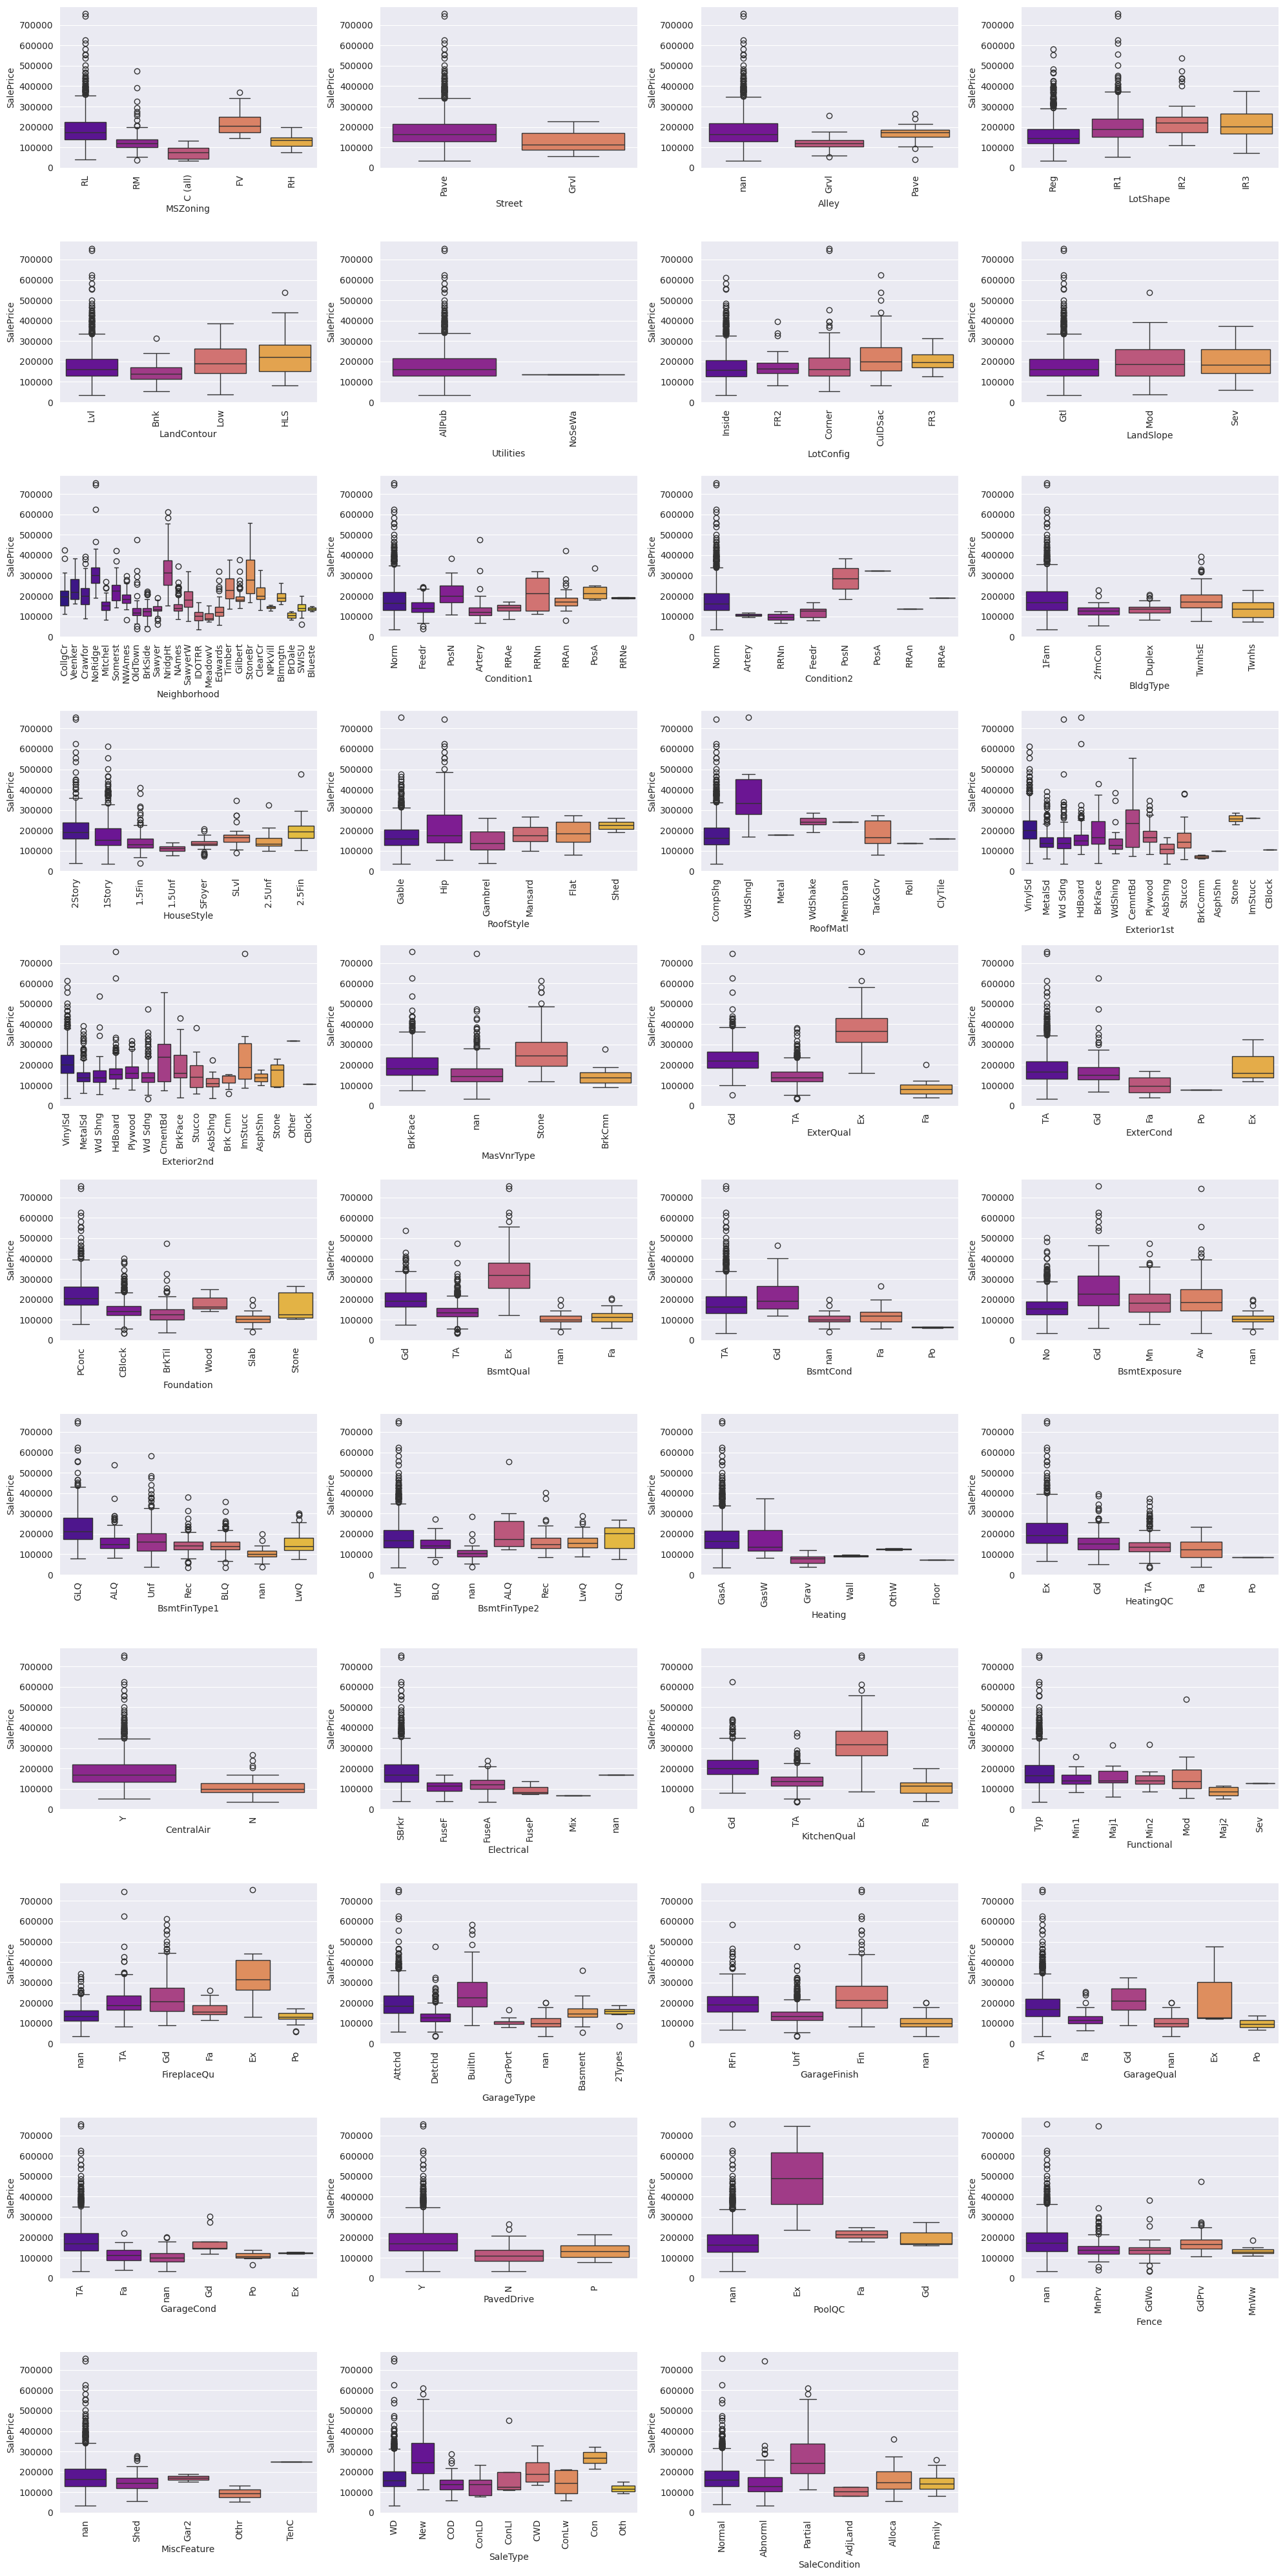

In [130]:
n_cols = cat_cols.shape[1]
cols_per_row = 4
rows = (n_cols + cols_per_row - 1) // cols_per_row

fig = plt.figure(figsize=(20, 40))

for idx in range(n_cols):
    ax = fig.add_subplot(rows, cols_per_row, idx + 1)
    col_name = cat_cols.columns[idx]
    sns.boxplot(x=train_data[col_name].astype(str), y=train_data['SalePrice'], ax=ax, palette='plasma', hue=train_data[col_name].astype(str))
    ax.set_xlabel(col_name)
    ax.set_ylabel('SalePrice')
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.tight_layout()
plt.show()

Основные выводы:
  - **MSZoning**: Высокая цена у районов с малой плотностью и престижных плавающих деревень.
  - **LandContour**: Дома на холмах дороже, на склонах — дешевле.
  - **Neighborhood**: Топ-3 дорогостоящих района — Northridge Heights, Northridge, Timberland; несколько районов с выше среднего ценами; ряд районов с низкими ценами.
  - **Conditions**: Близость к железной дороге и к положительным объектам (парки, зелёные зоны) повышает цену.
  - **MasVnrType**: Каменная облицовка дороже кирпичной.
  - **CentralAir**: Наличие центрального кондиционера повышает стоимость.
  - **GarageType**: Built-In гаражи имеют наивысшую цену, навесы — низшую.
  - **Misc**: Наличие теннисного корта заметно увеличивает цену.

# Предобработка данных

In [131]:
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

## Заполнение пропущенных значений

В датасете много пропусков, и их нельзя заполнить одним универсальным способом.  
Мы используем разные стратегии в зависимости от смысла признака:

1. **Категориальные признаки, где отсутствие объекта — это осмысленная категория**  
   - Примеры: `GarageType`, `FireplaceQu`, `PoolQC`, `Alley` и др.  
   - Если объекта нет, ставим `'NA'`.

2. **Числовые признаки, где отсутствие объекта = 0**  
   - Примеры: площади и санузлы подвала, `GarageArea`, `MasVnrArea`.  
   - Если объекта нет → заполняем `0`.

3. **Частые категории (мода)**  
   - Для признаков вроде `Electrical`, `KitchenQual`, `MSZoning` и др.  
   - Пропуски заменяем наиболее частым значением.

4. **GarageYrBlt (год постройки гаража)**  
   - Если гараж есть (`GarageType ≠ 'NA'`), а `GarageYrBlt` пропущен → заменяем на год постройки дома (`YearBuilt`).  
   - Если гаража нет → ставим `0`.

5. **LotFrontage (ширина участка)**  
   - Пропуски заполняем медианой внутри района (`Neighborhood`).

6. **Согласованность `MasVnrArea` и `MasVnrType`**  
   - Если `MasVnrArea = 0` → ставим `MasVnrType = 'NA'`.  
   - Если `MasVnrType = 'NA'` → принудительно ставим `MasVnrArea = 0`.

7. **Подвал (Basement)**  
   - Категориальные характеристики (`BsmtQual`, `BsmtCond` и др.) → `'NA'`.  
   - Числовые (`TotalBsmtSF`, `BsmtFullBath` и др.) → `0`.

---

После этих шагов мы проверяем статистику пропусков.  
Признаки `PoolQC`, `MiscFeature`, `Alley`, `Fence` содержат слишком много NaN и мало информации, поэтому удаляем их.

In [132]:
none_cols = [
    'Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]

for col in none_cols:
    train_data_copy[col] = train_data_copy[col].fillna('NA')
    test_data_copy[col] = test_data_copy[col].fillna('NA')

In [133]:
zero_cols = [
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    'BsmtFullBath', 'BsmtHalfBath', 'GarageArea', 'GarageCars', 'MasVnrArea'
]

for col in zero_cols:
    train_data_copy[col] = train_data_copy[col].fillna(0)
    test_data_copy[col] = test_data_copy[col].fillna(0)


In [134]:
for data in [train_data_copy, test_data_copy]:
    data.loc[(df['GarageType'] != 'NA') & (data['GarageYrBlt'].isna()), 'GarageYrBlt'] = data['YearBuilt']
    data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)

In [135]:
freq_cols = [
    'Electrical', 'Exterior1st', 'Exterior2nd',
    'Functional', 'KitchenQual', 'SaleType',
    'Utilities', 'MSZoning'
]

for col in freq_cols:
    mode_val = train_data_copy[col].mode()[0]
    train_data_copy[col] = train_data_copy[col].fillna(mode_val)
    test_data_copy[col] = test_data_copy[col].fillna(mode_val)

In [136]:
for data in [train_data_copy, test_data_copy]:
    data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [138]:
for data in [train_data_copy, test_data_copy]:
    data.loc[data['MasVnrArea'] == 0, 'MasVnrType'] = 'NA'
    data.loc[data['MasVnrType'] == 'NA', 'MasVnrArea'] = 0

In [139]:
bsmt_cols_cat = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
bsmt_cols_num = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']

for col in bsmt_cols_cat:
    for data in [train_data_copy, test_data_copy]:
        data[col] = data[col].replace('NA', np.nan)
        data[col] = data[col].fillna('NA')

for col in bsmt_cols_num:
    for data in [train_data_copy, test_data_copy]:
        data[col] = data[col].fillna(0)

Проверим остались ли пропуски в данных:

In [140]:
miss_train = get_missing_stats(train_data_copy)
miss_test = get_missing_stats(test_data_copy)

missing_data_df = pd.concat([miss_train, miss_test], axis=1, keys=['Train', 'Test']).fillna(0).astype({'Train': {'Total': int}, 'Test': {'Total': int}})
missing_data_df = missing_data_df.sort_values(('Train', 'Total'), ascending=False)

missing_data_df.style.background_gradient('rocket_r')

In [141]:
cols_drop_final = [
    'PoolQC',
    'MiscFeature',
    'Alley',
    'Fence'
]

train_data_copy = train_data_copy.drop(columns=cols_drop_final)
test_data_copy = test_data_copy.drop(columns=cols_drop_final)

## Кодирование категориальных признаков

Часть категориальных признаков несёт упорядоченную информацию, которая напрямую связана с качеством или уровнем удобств. Простая one-hot кодировка в таких случаях неэффективна: она теряет порядок категорий и раздувает размерность данных. Поэтому применяется ручное ранжирование категорий числовыми значениями, отражающими их естественную иерархию.

### Основные причины выбора такой кодировки:

1. **Сохранение информации о порядке (ordinal encoding)**  
   - Признаки вроде `ExterQual`, `KitchenQual`, `HeatingQC`, `GarageQual` имеют уровни качества: от *Poor (Po)* до *Excellent (Ex)*.  
   - Если закодировать их числами по возрастанию качества (например, `Po=0`, ..., `Ex=4`), модель сможет учитывать, что «Good» лучше, чем «Fair», и хуже, чем «Excellent».  

2. **Единый принцип для схожих признаков**  
   - Все показатели качества (`ExterCond`, `BsmtQual`, `FireplaceQu`, `GarageCond` и др.) закодированы по одной шкале: чем выше значение, тем лучше состояние/качество.  
   - Это делает интерпретацию модели более прозрачной и удобной.

3. **Учет отсутствующих значений (NA)**  
   - Для признаков, где возможен вариант «отсутствует» (`BsmtQual`, `FireplaceQu`, `GarageFinish`, `Fence`), категория `NA` интерпретируется как отдельный уровень и получает минимальное значение (обычно `0`).  
   - Такой подход позволяет не терять информацию: отсутствие подвала или камина тоже влияет на цену.

4. **Признаки с естественной упорядоченностью по уровню удобств**  
   - `LotShape`: Regular > Slightly Irregular > Moderately Irregular > Irregular.  
   - `Utilities`: All public > NoSewr > NoSeWa > Electricity only.  
   - `LandSlope`: Gentle > Moderate > Severe.  
   - В этих случаях порядок очевиден и связан с удобством проживания/строительства.

5. **Двоичные и простые категориальные признаки**  
   - Для простых бинарных признаков (`Street`, `CentralAir`) используется прямое кодирование (`Yes=1`, `No=0`), чтобы сохранить компактность и простоту.

---

### Таблица кодировки категориальных признаков

| Признак        | Категории (из описания данных) | Кодировка | Логика порядка |
|----------------|--------------------------------|-----------|----------------|
| **LotShape**   | `Reg` (Regular) → `IR1` (Slightly irregular) → `IR2` (Moderately irregular) → `IR3` (Irregular) | 3, 2, 1, 0 | Чем более правильная форма участка, тем выше ценность. |
| **Utilities**  | `AllPub` (Все коммунальные) → `NoSewr` (Без канализации) → `NoSeWa` (Без канализации и воды) → `ELO` (Только электричество) | 3, 2, 1, 0 | Полный набор коммуникаций повышает стоимость. |
| **LandSlope**  | `Gtl` (Gentle) → `Mod` (Moderate) → `Sev` (Severe) | 2, 1, 0 | Более пологий участок предпочтительнее. |
| **ExterQual**  | `Ex` (Excellent) → `Gd` (Good) → `TA` (Typical/Average) → `Fa` (Fair) → `Po` (Poor) | 4, 3, 2, 1, 0 | Прямая оценка качества наружных материалов. |
| **ExterCond**  | `Ex` → `Gd` → `TA` → `Fa` → `Po` | 4, 3, 2, 1, 0 | Прямая оценка состояния наружных материалов. |
| **BsmtQual**   | `Ex` (100+ inches) → `Gd` (90–99") → `TA` (80–89") → `Fa` (70–79") → `Po` (<70") → `NA` (Нет подвала) | 5, 4, 3, 2, 1, 0 | Чем выше потолки в подвале, тем лучше. Отсутствие подвала – худший случай. |
| **BsmtCond**   | `Ex` (Excellent) → `Gd` → `TA` → `Fa` → `Po` → `NA` | 5, 4, 3, 2, 1, 0 | Чем лучше состояние подвала, тем выше балл. |
| **BsmtExposure** | `Gd` (Good Exposure) → `Av` (Average) → `Mn` (Minimum) → `No` (None) → `NA` | 4, 3, 2, 1, 0 | Наличие и качество освещённости/выхода из подвала увеличивает ценность. |
| **BsmtFinType1/2** | `GLQ` (Good Living Quarters) → `ALQ` (Average Living Quarters) → `BLQ` (Below Average) → `Rec` (Rec Room) → `LwQ` (Low Quality) → `Unf` (Unfinished) → `NA` | 6, 5, 4, 3, 2, 1, 0 | Более качественная отделка подвала увеличивает стоимость. |
| **HeatingQC**  | `Ex` → `Gd` → `TA` → `Fa` → `Po` | 4, 3, 2, 1, 0 | Качество отопления напрямую влияет на комфорт. |
| **KitchenQual** | `Ex` → `Gd` → `TA` → `Fa` → `Po` | 4, 3, 2, 1, 0 | Качество кухни — важный фактор для покупателей. |
| **FireplaceQu** | `Ex` → `Gd` → `TA` → `Fa` → `Po` → `NA` | 5, 4, 3, 2, 1, 0 | Более качественный камин повышает ценность. Отсутствие камина = 0. |
| **GarageFinish** | `Fin` (Finished) → `RFn` (Rough Finished) → `Unf` (Unfinished) → `NA` | 3, 2, 1, 0 | Чем более готова внутренняя отделка гаража, тем лучше. |
| **GarageQual** | `Ex` → `Gd` → `TA` → `Fa` → `Po` → `NA` | 5, 4, 3, 2, 1, 0 | Прямая оценка качества гаража. |
| **GarageCond** | `Ex` → `Gd` → `TA` → `Fa` → `Po` → `NA` | 5, 4, 3, 2, 1, 0 | Прямая оценка состояния гаража. |
| **PavedDrive** | `Y` (Paved) → `P` (Partial) → `N` (Dirt/Gravel) | 2, 1, 0 | Асфальтированный проезд — наиболее предпочтителен. |
| **Fence**      | `GdPrv` (Good Privacy) → `MnPrv` (Minimum Privacy) → `GdWo` (Good Wood) → `MnWw` (Minimum Wood/Wire) → `NA` | 4, 3, 2, 1, 0 | Забор повышает приватность и ценность. |
| **CentralAir** | `Y` (Yes) → `N` (No) | 1, 0 | Наличие кондиционера — преимущество. |
| **Street**     | `Pave` (Paved) → `Grvl` (Gravel) | 1, 0 | Асфальтированная дорога предпочтительнее. |


In [142]:
mapping_dict = {
    'LotShape': {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0},
    'Utilities': {'AllPub': 3, 'NoSewr': 2, 'NoSeWa': 1, 'ELO': 0},
    'LandSlope': {'Gtl': 2, 'Mod': 1, 'Sev': 0},
    'ExterQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'ExterCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0},
    'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0},
    'HeatingQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0},
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'PavedDrive': {'Y': 2, 'P': 1, 'N': 0},
    'CentralAir': {'Y': 1, 'N': 0},
    'Street': {'Pave': 1, 'Grvl': 0}
}

for col, mapping in mapping_dict.items():
    train_data_copy[col] = train_data_copy[col].map(mapping)
    test_data_copy[col] = test_data_copy[col].map(mapping)

Не все категориальные признаки имеют упорядоченную структуру. Многие из них являются номинальными (категории без естественного порядка), например: район (`Neighborhood`), тип дома (`HouseStyle`), тип кровли (`RoofStyle`) и др.  

Для таких признаков используется **one-hot кодировка** с помощью `pd.get_dummies`. Она создаёт бинарные индикаторы (0/1) для каждой категории, позволяя модели учитывать наличие/отсутствие признака без навязывания искусственного порядка.

### Причины использования one-hot кодировки:

1. **Отсутствие естественного порядка категорий**  
   - Например, в `Neighborhood` значения `CollgCr`, `OldTown`, `NridgHt` — это просто названия районов, и они не сопоставимы по «лучшему» или «худшему» порядку.  
   - Присвоение чисел (1,2,3) ввело бы модель в заблуждение, т.к. это означало бы линейную зависимость, которой нет.

2. **Сохранение всей информации о признаке**  
   - One-hot кодировка даёт модели возможность различать каждую категорию отдельно.  
   - Например, наличие гаража с типом `Detchd` (отдельный) никак не сопоставимо с `BuiltIn`, но оба варианта могут по-разному влиять на цену.

3. **Избежание ошибочной интерпретации**  
   - Если бы мы использовали порядковое кодирование, то модель могла бы интерпретировать «Townhouse Inside Unit (TwnhsI)» как хуже или лучше, чем «Townhouse End Unit (TwnhsE)», что неверно.

4. **Использование `drop_first=True`**  
   - Чтобы избежать **мультиколлинеарности**, при кодировке одна из категорий отбрасывается (базовый уровень).  
   - Например, если `Street` кодируется в {Grvl, Pave}, то сохраняется только один бинарный индикатор (`Street_Pave`), а `Street_Grvl` можно восстановить по отсутствию признака.

---

In [143]:
cat_cols = train_data_copy.select_dtypes(include=['object', 'category']).columns.tolist()
ordinal_cols = list(mapping_dict.keys())
onehot_cols = [col for col in cat_cols if col not in ordinal_cols]

train_data_copy = pd.get_dummies(train_data_copy, columns=onehot_cols, drop_first=True).astype(int)
test_data_copy = pd.get_dummies(test_data_copy, columns=onehot_cols, drop_first=True).astype(int)

train_data_copy, test_data_copy = train_data_copy.align(test_data_copy, join="left", axis=1, fill_value=0)

Посмотрим на данные после кодирования категориальных признаков

In [144]:
train_data_copy.sample(15)

MSSubClass  LotFrontage  LotArea  Street  LotShape  Utilities  \
Id                                                                    
1450         180           21     1533       1         3          3   
628           80           80     9600       1         3          3   
544          120           34     4058       1         3          3   
1444          30           52     8854       1         3          3   
1371          50           90     5400       1         3          3   
734           20           80    10000       1         3          3   
328           20           80    11600       1         3          3   
856           20           71     6897       1         2          3   
395           50           60    10134       1         3          3   
781           20           63     7875       1         3          3   
1332          80           55    10780       1         2          3   
24           120           44     4224       1         3          3   
765          120           30     9549       1         2          3   
655           20           91    10437       1         2          3   
1117          80           65     7750       1         3          3   

      LandSlope  OverallQual  OverallCond  YearBuilt  ...  SaleType_ConLI  \
Id                                                    ...                   
1450          2            5            7       1970  ...               0   
628           2            6            6       1955  ...               0   
544           2            7            5       1998  ...               0   
1444          2            6            6       1916  ...               0   
1371          2            4            6       1920  ...               0   
734           2            5            6       1961  ...               0   
328           2            6            5       1960  ...               0   
856           2            5            8       1962  ...               0   
395           2            5            6       1940  ...               0   
781           2            7            5       1995  ...               0   
1332          2            5            5       1976  ...               0   
24            2            5            7       1976  ...               0   
765           2            8            5       1995  ...               0   
655           2            8            6       1995  ...               0   
1117          2            8            5       2002  ...               0   

      SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
Id                                                              
1450               0             0             0            1   
628                0             0             0            1   
544                0             0             0            1   
1444               0             0             0            1   
1371               0             0             0            1   
734                0             0             0            1   
328                0             0             0            1   
856                0             0             0            1   
395                0             0             0            1   
781                0             0             0            1   
1332               0             0             0            1   
24                 0             0             0            1   
765                0             0             0            1   
655                0             0             0            1   
1117               0             0             0            1   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
Id                                                                        
1450                      0                     0                     0   
628                       0                     0                     0   
544                       0                     0                     0   
1444   

## Удаление выбросов

На этапе **EDA (Exploratory Data Analysis)** были выявлены экстремальные значения по ключевым признакам, которые сильно отклоняются от основной массы данных. Эти выбросы могут негативно влиять на обучение модели, и поэтому на этапе **предобработки данных** они были удалены.  

**Цель:** повысить устойчивость модели, снизить влияние редких аномалий и улучшить качество предсказаний.

In [145]:
train_data_copy = train_data_copy.drop(train_data_copy['LotFrontage']
                                     [train_data_copy['LotFrontage']>200].index)
train_data_copy = train_data_copy.drop(train_data_copy['LotArea']
                                     [train_data_copy['LotArea']>100000].index)
train_data_copy = train_data_copy.drop(train_data_copy['BsmtFinSF1']
                                     [train_data_copy['BsmtFinSF1']>4000].index)
train_data_copy = train_data_copy.drop(train_data_copy['TotalBsmtSF']
                                     [train_data_copy['TotalBsmtSF']>6000].index)
train_data_copy = train_data_copy.drop(train_data_copy['1stFlrSF']
                                     [train_data_copy['1stFlrSF']>4000].index)
train_data_copy = train_data_copy.drop(train_data_copy.GrLivArea
                                     [(train_data_copy['GrLivArea']>4000) & 
                                      (target<300000)].index)
train_data_copy = train_data_copy.drop(train_data_copy.LowQualFinSF
                                     [train_data_copy['LowQualFinSF']>550].index)

# Feature Engineering

На этапе фичи-инжиниринга были созданы дополнительные признаки, которые объединяют существующую информацию, увеличивают информативность и помогают модели учитывать сложные зависимости между характеристиками дома.

**Цель:** улучшить предсказательную способность модели, выделяя ключевые аспекты, влияющие на цену: размер, качество, удобства, возраст дома и взаимодействие с районами.

---

### 1. Суммарные площади
- **TotalSF** – общая площадь дома (подвал + первый и второй этажи).  
- **TotalPorchSF** – суммарная площадь всех веранд, террас и открытых пространств.  

*Почему важно:* размер жилья и дополнительные удобства напрямую влияют на стоимость. Агрегирование отдельных площадей упрощает модели оценку влияния на цену.

---

### 2. Ванные комнаты
- **TotalBathrooms** – суммарное количество ванных комнат с учётом половинных (0.5).  

*Зачем:* отражает комфорт и удобство проживания; больше санузлов обычно повышает привлекательность дома.

---

### 3. Возраст дома и время с ремонта
- **HouseAge** – возраст дома на момент продажи.  
- **SinceRemodel** – количество лет с последнего капитального ремонта.  

*Смысл:* более старые дома или дома с давно проведённым ремонтом могут стоить дешевле, а недавно обновлённые дома — дороже.

---

### 4. Суммарные показатели качества
- **TotalExtQual** – качество экстерьера и его состояние.  
- **TotalBsmQual** – суммарная оценка подвала (качество, состояние, отделка).  
- **TotalGrgQual** – качество и состояние гаража.  
- **TotalQual** – агрегированный показатель качества всего дома (включает экстерьер, подвал, гараж, кухню и отопление).  

*Почему:* объединение отдельных показателей качества в один числовой признак упрощает оценку ценности дома и помогает модели учесть все ключевые аспекты одновременно.

---

### 5. Комбинация качества и площади
- **QualGr**, **QualBsm**, **QualPorch**, **QualExt**, **QualGrg**, **QlLivArea** – произведение площади на суммарное качество соответствующей зоны.  

*Зачем:* учитывает, что ценность помещения зависит не только от размера, но и от качества отделки/состояния. Например, большая, но низкокачественная комната менее ценна, чем средняя по площади, но с высоким качеством.

---

### 6. Взаимодействие с районами
- **QualGr_[Neighborhood_...]** – произведение признака **QualGr** на One-Hot столбцы районов.  

*Смысл:* эффект качества жилой площади может зависеть от района; позволяет модели изучить локальные закономерности ценообразования.

---

In [146]:
def create_features(data):
    data['TotalSF'] = data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF']
    data['TotalPorchSF'] = data['OpenPorchSF'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF']

    data['TotalBathrooms'] = (
        data['FullBath'] + 0.5 * data['HalfBath'] +
        data['BsmtFullBath'] + 0.5 * data['BsmtHalfBath']
    )

    data['HouseAge'] = data['YrSold'] - data['YearBuilt']
    data['SinceRemodel'] = data['YrSold'] - data['YearRemodAdd']

    data['TotalExtQual'] = data['ExterQual'] + data['ExterCond']
    data['TotalBsmQual'] = data['BsmtQual'] + data['BsmtCond'] + data['BsmtFinType1'] + data['BsmtFinType2']
    data['TotalGrgQual'] = data['GarageQual'] + data['GarageCond']
    data['TotalQual'] = (
        data['OverallQual'] + data['TotalExtQual'] +
        data['TotalBsmQual'] + data['TotalGrgQual'] +
        data['KitchenQual'] + data['HeatingQC']
    )

    data['QualGr'] = data['TotalQual'] * data['GrLivArea']
    data['QualBsm'] = data['TotalBsmQual'] * (data['BsmtFinSF1'] + data['BsmtFinSF2'])
    data['QualPorch'] = data['TotalExtQual'] * data['TotalPorchSF']
    data['QualExt'] = data['TotalExtQual'] * data['MasVnrArea']
    data['QualGrg'] = data['TotalGrgQual'] * data['GarageArea']
    data['QlLivArea'] = (data['GrLivArea'] - data['LowQualFinSF']) * data['TotalQual']

    neighborhood_cols = [col for col in data.columns if col.startswith('Neighborhood_')]
    for col in neighborhood_cols:
        data[f'QualGr_{col}'] = data['QualGr'] * data[col]

    return data

In [147]:
train_data_copy = create_features(train_data_copy)
test_data_copy = create_features(test_data_copy)

In [148]:
new_features = ['TotalSF', 'TotalPorchSF','TotalBathrooms','HouseAge', 'SinceRemodel',
                'TotalExtQual', 'TotalBsmQual', 'TotalGrgQual', 'TotalQual',
                'QualGr', 'QualBsm', 'QualPorch', 'QualExt', 'QualGrg', 'QlLivArea'
]

neighborhood_cols = [col for col in train_data_copy.columns if col.startswith('QualGr_Neighborhood_')]
new_features += neighborhood_cols


corr_with_target = train_data_copy[new_features + ['SalePrice']].corr()['SalePrice'].sort_values(ascending=False)

print("Корреляция новых признаков с SalePrice:")
print(corr_with_target)
print("\n" + "="*50 + "\n")


corr_matrix = train_data_copy[new_features].corr()
high_corr = (corr_matrix.abs() > 0.8) & (corr_matrix.abs() < 1.0)

print("Сильнокоррелированные признаки (мультиколлинеарность):")
for col in high_corr.columns:
    correlated = list(high_corr.index[high_corr[col]])
    if correlated:
        print(f"{col} сильно коррелирует с: {correlated}")

Корреляция новых признаков с SalePrice:
SalePrice                      1.000000
QlLivArea                      0.876147
QualGr                         0.872431
TotalSF                        0.758520
TotalQual                      0.704491
TotalBathrooms                 0.636372
QualGrg                        0.628835
TotalExtQual                   0.595088
QualExt                        0.542018
QualPorch                      0.483147
QualGr_Neighborhood_NridgHt    0.453455
QualBsm                        0.449918
TotalBsmQual                   0.409551
TotalPorchSF                   0.391617
QualGr_Neighborhood_NoRidge    0.387404
TotalGrgQual                   0.268474
QualGr_Neighborhood_StoneBr    0.254983
QualGr_Neighborhood_Somerst    0.168810
QualGr_Neighborhood_Timber     0.137906
QualGr_Neighborhood_CollgCr    0.133695
QualGr_Neighborhood_Crawfor    0.113171
QualGr_Neighborhood_Veenker    0.077752
QualGr_Neighborhood_SawyerW    0.064592
QualGr_Neighborhood_Gilbert    0.054246


После создания дополнительных признаков важно оценить их информативность и возможную мультиколлинеарность. Для этого был проведён корреляционный анализ с целевой переменной `SalePrice` и между самими признаками.

---

### 1. Площади

- **QlLivArea** (Adjusted Living Area Quality)  
  - Комбинирует жилую площадь с общей оценкой качества дома.  
  - Имеет сильную положительную корреляцию с `SalePrice` (≈0.876).  
  - Учитывает одновременно площадь и качество отделки.  
  - **Рекомендация:** оставить в модели.

- **TotalSF** (Общая площадь дома, включая подвалы и этажи)  
  - Коррелирует с `SalePrice` (≈0.758), но сильно коррелирует с производными признаками `QlLivArea` и `QualGr`.  
  - **Рекомендация:** отбросить из-за избыточности.

- **TotalPorchSF** (Суммарная площадь веранд и террас)  
  - Сильно коррелирует с производным признаком `QualPorch`.  
  - **Рекомендация:** оставить только `QualPorch`.

---

### 2. Ванные комнаты

- **TotalBathrooms**  
  - Включает полные и половинные ванные, включая подвал.  
  - Корреляция с `SalePrice` ≈0.636, информативный признак.  
  - **Рекомендация:** оставить.

---

### 3. Возраст дома и ремоделинг

- **HouseAge** (Возраст дома)  
  - Отрицательная корреляция с `SalePrice` (≈-0.537).  
  - Информативен и не сильно коррелирует с другими признаками.  
  - **Рекомендация:** оставить.

- **SinceRemodel** (Лет с последнего ремонта)  
  - Отрицательная корреляция с `SalePrice` (≈-0.513).  
  - Дополняет признак возраста дома, отражая состояние после ремонта.  
  - **Рекомендация:** оставить.

---

### 4. Качество отделки

- **TotalQual**  
  - Агрегирует ключевые оценки качества дома (экстерьер, подвал, гараж, кухня, отопление).  
  - Корреляция с `SalePrice` ≈0.704.  
  - Используется вместо отдельных сильно коррелирующих признаков для уменьшения мультиколлинеарности.  

- **Производные показатели качества**:  
  - `TotalExtQual`, `TotalBsmQual`, `TotalGrgQual` — информативны для диагностики, но сильно коррелируют с `TotalQual`, поэтому в модель не включаются.  
  - `QualGr` (TotalQual * GrLivArea) — сильная корреляция с `SalePrice` (≈0.872), мультиколлинеарен с `QlLivArea`. Можно оставить оба.  
  - `QualBsm` — корреляция ниже, мультиколлинеарен с `TotalQual`, необязателен.  
  - `QualPorch` — заменяет `TotalPorchSF`, более информативен, оставляем.  
  - `QualExt` — полезный производный признак экстерьера, оставляем.  
  - `QualGrg` — отражает качество и площадь гаража, оставляем.

---

### 5. Взаимодействие с районами

- **QualGr_Neighborhood_...**  
  - Создаются как произведение `QualGr` на one-hot столбцы районов.  
  - Сильная корреляция с `SalePrice` только для некоторых районов (`NridgHt`, `NoRidge`).  
  - Остальные добавляют шум и мало информативны.  
  - **Рекомендация:** оставить только сильнокоррелирующие районы.

---

### 6. Итоговая рекомендация

**Оставляем для модели:**  
`QlLivArea, QualGr, TotalQual, TotalBathrooms, QualGrg, TotalExtQual, QualExt, QualPorch, HouseAge, SinceRemodel, QualGr_Neighborhood_NridgHt, QualGr_Neighborhood_NoRidge`  


# Feature Selection

После создания новых признаков и анализа их корреляции с целевой переменной было принято решение о **выборе наиболее информативных признаков** и удалении избыточных или сильно коррелирующих.

**Цель:** уменьшить размерность данных, снизить мультиколлинеарность, исключить малоинформативные признаки и улучшить качество модели.

---

### 1. Исключение исходных и менее информативных признаков

Были удалены следующие признаки:

- `GarageArea`, `GarageYrBlt`, `TotRmsAbvGrd`, `1stFlrSF` — исходные признаки, по которым уже созданы производные (например, `QualGrg`, `QlLivArea`).  
- `MSSubClass`, `MoSold`, `YrSold`, `MiscVal` — категориальные или числовые признаки, которые не влияют на целевую переменную после создания новых признаков.  
- `BsmtFinSF2`, `BsmtUnfSF`, `LowQualFinSF`, `3SsnPorch` — малозначимые или слабо коррелирующие с ценой признаки.

*Причина:* эти признаки либо дублируют информацию, уже учтенную в производных, либо малоинформативны, поэтому их удаление помогает модели работать эффективнее.

---

### 2. Отбор наиболее информативных признаков

Были оставлены следующие признаки:

- Основные производные признаки площади и качества:  
  `QlLivArea`, `QualGr`, `TotalQual`, `TotalBathrooms`, `QualGrg`, `TotalExtQual`, `QualExt`, `QualPorch`.  
  *Смысл:* учитывают размер, качество дома и ключевые удобства.

- Признаки возраста и времени с ремонта:  
  `HouseAge`, `SinceRemodel`.  
  *Смысл:* отражают состояние дома и его влияние на цену.

- Взаимодействия с районами:  
  `QualGr_Neighborhood_NridgHt`, `QualGr_Neighborhood_NoRidge`.  
  *Смысл:* сильнокоррелирующие взаимодействия с районами, влияющими на стоимость.

---

### 3. Итог

- **Удалены**: признаки, дублирующие информацию, малозначимые или сильно коррелирующие с оставленными производными.  
- **Оставлены**: признаки с высокой корреляцией с ценой и высокой информативностью для модели.

*Результат:* уменьшение размерности, снижение мультиколлинеарности и сохранение всех ключевых факторов, влияющих на цену дома.

In [149]:
cols_drop = [
    'GarageArea','GarageYrBlt','TotRmsAbvGrd','1stFlrSF','MSSubClass',
    'MoSold','YrSold','MiscVal','BsmtFinSF2','BsmtUnfSF',
    'LowQualFinSF','3SsnPorch'
]
train_data_copy = train_data_copy.drop(cols_drop, axis=1)
test_data_copy = test_data_copy.drop(cols_drop, axis=1)


In [150]:
features_to_keep = [
    'QlLivArea', 'QualGr', 'TotalQual', 'TotalBathrooms', 
    'QualGrg', 'TotalExtQual', 'QualExt', 'QualPorch', 
    'HouseAge', 'SinceRemodel',
    'QualGr_Neighborhood_NridgHt', 'QualGr_Neighborhood_NoRidge'
]

features_to_drop = [f for f in new_features if f not in features_to_keep]
train_data_copy = train_data_copy.drop(columns=features_to_drop, errors='ignore')
test_data_copy = test_data_copy.drop(columns=features_to_drop, errors='ignore')

# Моделирование

## Train/Validation Split + логарифмирование таргета

### Подготовка данных к моделированию  

1. **Разделение признаков и целевой переменной**  
   - Целевая переменная `SalePrice` преобразуется с помощью `log1p`.  
   - Логарифмирование снижает асимметрию распределения цен, делает задачу более устойчивой к выбросам и улучшает сходимость модели.  

2. **Train/Validation split**  
   - Данные делятся на обучающую и валидационную выборки (`80/20`).  
   - Фиксируется `random_state=42` для воспроизводимости.  
   - Валидационная выборка нужна для контроля качества модели и предотвращения переобучения.  

3. **Кросс-валидация (KFold)**  
   - Используется 5-фолдовая кросс-валидация с перемешиванием.  
   - Это обеспечивает более надёжную оценку качества модели, так как результат усредняется по нескольким фолдам.  


In [151]:
X = train_data_copy.drop(columns=['SalePrice'])
y = np.log1p(train_data_copy['SalePrice'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Оптимизация гиперпараметров

На данном этапе для каждой модели регрессии проводится **автоматический подбор оптимальных гиперпараметров с помощью Optuna**.  

**Цель:**  
- Минимизировать ошибку предсказаний (RMSE) на тренировочном наборе.  
- Избежать ручного подбора параметров и повысить стабильность моделей.  
- Сделать обучение более эффективным и точным.

---

### 1. Линейные модели (Ridge, Lasso, ElasticNet)

- Подбираются:
  - **`alpha`** — коэффициент регуляризации, контролирующий переобучение.  
  - Для ElasticNet дополнительно **`l1_ratio`** — баланс между L1 и L2 регуляризацией.  
- **Смысл:** оптимальная регуляризация позволяет модели находить общий тренд без сильного влияния отдельных признаков.

---

### 2. Градиентный бустинг (GradientBoostingRegressor)

- Подбираются:
  - Количество деревьев (`n_estimators`) и глубина (`max_depth`).  
  - Скорость обучения (`learning_rate`).  
  - Минимальное число объектов в листе (`min_samples_leaf`).  
  - Доля признаков и выборка данных для каждого дерева (`max_features`, `subsample`).  
- **Смысл:** позволяет модели захватывать сложные зависимости между признаками, одновременно избегая переобучения.

---

### 3. XGBoost и LightGBM

- Подбираются:
  - Параметры деревьев и скорость обучения.  
  - Регуляризация (`reg_alpha`, `reg_lambda`) и подвыборка признаков (`colsample_bytree`).  
  - Для LightGBM также количество листьев и глубина деревьев.  
- **Смысл:** оптимальные параметры обеспечивают баланс между точностью и обобщающей способностью модели.

---

### 4. CatBoost

- Подбираются:
  - Количество итераций, глубина деревьев, скорость обучения.  
  - L2-регуляризация (`l2_leaf_reg`).  
- **Особенности:** CatBoost автоматически обрабатывает категориальные признаки, поэтому ключевыми являются глубина деревьев и регуляризация.

---

### 5. Принцип работы оптимизации

1. Для каждой модели создаётся функция, которая:
   - Формирует модель с текущими гиперпараметрами (`trial`).  
   - Оценивает качество через 5-кратную кросс-валидацию на тренировочном наборе (`X_train`, `y_train`) с метрикой **отрицательный RMSE**.  
   - Возвращает значение для минимизации Optuna.

2. Функция `run_optuna`:
   - Создаёт исследование (`study`) с направлением **минимизации**.  
   - Запускает оптимизацию на заданное число итераций (`n_trials`).  
   - Возвращает **лучшие гиперпараметры**, найденные на тренировочном наборе.

---

### 6. Результат

Каждая модель получает свой оптимальный набор параметров:

- `best_ridge`, `best_lasso`, `best_elastic` — линейные модели.  
- `best_gbr` — градиентный бустинг.  
- `best_xgb`, `best_lgb` — XGBoost и LightGBM.  
- `best_cat` — CatBoost.  

**Преимущества такого подхода:**  
- Минимизация RMSE без ручного подбора.  
- Стабильность и воспроизводимость моделей.  
- Оптимальный баланс между точностью и переобучением.

In [152]:
def optimize_linear(trial, model_type):
    if model_type == 'Ridge':
        alpha = trial.suggest_float('alpha', 0.01, 50.0)
        model = Ridge(alpha=alpha, random_state=42)
    elif model_type == 'Lasso':
        alpha = trial.suggest_float('alpha', 0.0001, 0.5)
        model = Lasso(alpha=alpha, max_iter=20000, random_state=42)
    else:  # ElasticNet
        alpha = trial.suggest_float('alpha', 0.0001, 0.5)
        l1_ratio = trial.suggest_float('l1_ratio', 0.05, 0.95)
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=20000, random_state=42)
    
    score = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error').mean()
    return -score

In [153]:
def optimize_gbr(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 20),
        'max_features': 'sqrt',
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'loss': 'huber',
        'random_state': 42
    }
    model = GradientBoostingRegressor(**param)
    score = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error').mean()
    return -score

In [154]:
def optimize_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 2.0),
        'objective': 'reg:squarederror',
        'random_state': 42,
        'verbosity': 0
    }
    model = xgb.XGBRegressor(**param)
    score = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error').mean()
    return -score

In [155]:
def optimize_lgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 31, 150),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42,
        'verbose': -1
    }
    model = lgb.LGBMRegressor(**param)
    score = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error').mean()
    return -score

In [156]:
def optimize_cat(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 1000, 3000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_state': 42,
        'verbose': 0
    }
    model = CatBoostRegressor(**param)
    score = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error').mean()
    return -score

In [157]:
def run_optuna(obj, n_trials=50):
    study = optuna.create_study(direction='minimize')
    study.optimize(obj, n_trials=n_trials)
    return study.best_params

In [158]:
best_ridge = run_optuna(lambda t: optimize_linear(t, 'Ridge'))
best_lasso = run_optuna(lambda t: optimize_linear(t, 'Lasso'))
best_elastic = run_optuna(lambda t: optimize_linear(t, 'ElasticNet'))
best_gbr = run_optuna(optimize_gbr)
best_xgb = run_optuna(optimize_xgb)
best_lgb = run_optuna(optimize_lgb)
best_cat = run_optuna(optimize_cat)

## Инициализация моделей с лучшими параметрами

На этом шаге мы инициализируем все модели, которые будем использовать для предсказания, с уже найденными оптимальными гиперпараметрами.  

- Для **линейных моделей** (`Ridge`, `Lasso`, `ElasticNet`) параметры регуляризации уже настроены на минимизацию RMSE, что помогает контролировать переобучение и повышает стабильность предсказаний.  
- Для **ансамблевых моделей** (`GradientBoostingRegressor`, `XGBRegressor`, `LGBMRegressor`) подобраны параметры глубины деревьев, скорости обучения, числа листьев и других важных гиперпараметров, чтобы модели лучше улавливали сложные зависимости в данных.  
- Для **CatBoost** параметры итераций, глубины и L2-регуляризации настроены так, чтобы обеспечить высокое качество предсказаний при минимальном переобучении.

Таким образом, каждая модель готова к обучению на тренировочных данных с наилучшими найденными настройками, что повышает точность и надёжность итогового прогноза.

In [159]:
ridge_model = Ridge(**best_ridge)
lasso_model = Lasso(**best_lasso)
elastic_model = ElasticNet(**best_elastic)
gbr_model = GradientBoostingRegressor(**best_gbr)
xgb_model = xgb.XGBRegressor(**best_xgb)
lgb_model = lgb.LGBMRegressor(**best_lgb, verbosity=-1)
cat_model = CatBoostRegressor(**best_cat, verbose=0)

## Построение стекинга

На этом этапе все обученные модели объединяются в **стекинг-конструкцию**, чтобы использовать сильные стороны каждой модели и повысить общую точность предсказаний.

---

### 1. Базовые модели (`estimators`)

- Включают все ранее настроенные модели:  
  - Линейные: `Ridge`, `Lasso`, `ElasticNet`  
  - Ансамблевые: `GradientBoosting`, `XGB`, `LGBM`, `CatBoost`  
- **Принцип работы:** каждая базовая модель обучается на тренировочных данных и генерирует свои предсказания.  
- Эти предсказания станут входными признаками для мета-модели.

---

### 2. Мета-модель (`meta_model`)

- Используется XGBoost регрессор, обучающийся на предсказаниях базовых моделей.  
- **Задача:** определить, как лучше комбинировать предсказания базовых моделей для получения более точного итогового результата.  
- Параметры мета-модели (число деревьев, глубина, скорость обучения, подвыборка признаков) выбраны для баланса между точностью и стабильностью.

---

### 3. Стекинг-конструкция (`StackingRegressor`)

- `cv=kf` задаёт кросс-валидацию для обучения базовых и мета-моделей, что снижает риск переобучения.  
- `passthrough=True` позволяет мета-модели использовать исходные признаки вместе с предсказаниями базовых моделей, повышая качество предсказаний.  
- `n_jobs=-1` обеспечивает параллельное обучение всех моделей, ускоряя процесс.

---

### Итог

- Создан ансамбль, объединяющий различные алгоритмы.  
- Обеспечивает **устойчивое и более точное предсказание**, чем любая отдельная модель.  
- Стекинг позволяет использовать сильные стороны как линейных, так и ансамблевых моделей, улучшая финальный результат.

In [160]:
estimators = [
    ('ridge', ridge_model),
    ('lasso', lasso_model),
    ('elastic', elastic_model),
    ('gbr', gbr_model),
    ('xgb', xgb_model),
    ('lgb', lgb_model),
    ('cat', cat_model)
]

meta_model = xgb.XGBRegressor(
    n_estimators=2000,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42
)

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    cv=kf,
    n_jobs=-1,
    passthrough=True
)

На этом этапе создаются **OOF-предсказания** для каждой модели.  
Это позволяет получить честную оценку качества моделей на кросс-валидации и подготовить данные для анализа или дальнейшего мета-обучения.

---

### 1. Массив моделей (`models`)

- Включает все индивидуальные модели: `Ridge`, `Lasso`, `ElasticNet`, `GradientBoosting`, `XGB`, `LGBM`, `CatBoost`.  
- Также добавлен финальный стекинг-ансамбль.  
- **Зачем:** одновременно оцениваем производительность отдельных алгоритмов и ансамбля.

---

### 2. Инициализация OOF массива (`oof_preds`)

- Размерность массива: `(количество объектов, количество моделей)`.  
- В каждой колонке хранятся предсказания модели **только на валидационных фолдах**, что предотвращает утечку информации из тренировочных данных.

---

### 3. Кросс-валидация по KFold

- Для каждой модели выполняется KFold-разбиение данных:  
  - `X_tr, y_tr` — обучающая часть фолда.  
  - `X_va` — валидационная часть фолда.  
- Модель обучается на тренировочных данных и предсказывает целевую переменную на валидационном фолде.

---

### 4. Сбор предсказаний

- Предсказания каждой модели для всех объектов объединяются в соответствующую колонку OOF-массива.  
- В итоге массив `oof_preds` содержит кросс-валидационные предсказания всех моделей на всём датасете.  
- **Использование OOF-предсказаний:**
  - Анализ ошибок и диагностика моделей.  
  - Честная оценка метрик на кросс-валидации.  
  - Подготовка признаков для обучения мета-модели или последующего стекинга.

---

### Итог

- OOF-предсказания позволяют получить **честные оценки качества моделей**, исключая утечку данных.  
- Это важный шаг для построения надёжного стекинг-ансамбля и дальнейшего улучшения итоговых предсказаний.

In [161]:
models = [ridge_model, lasso_model, elastic_model, gbr_model, xgb_model, lgb_model, cat_model, stack]

oof_preds = np.zeros((X.shape[0], len(models)))

for i, model in enumerate(models):
    temp_preds = np.zeros(X.shape[0])
    for train_idx, val_idx in kf.split(X):
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr = y.iloc[train_idx]
        model.fit(X_tr, y_tr)
        temp_preds[val_idx] = model.predict(X_va)
    oof_preds[:, i] = temp_preds

## Взвешенное объединение (блендинг) предсказаний моделей

На этом этапе мы используем библиотеку **Optuna** для подбора оптимальных весов при объединении предсказаний всех моделей.  
Цель — найти наилучшее соотношение влияния каждой модели, чтобы повысить точность финального ансамбля.

---

### 1. Функция оптимизации (`optimize_blend`)

- Для каждой итерации случайным образом предлагаются веса для всех моделей.  
- Веса нормализуются так, чтобы их сумма была равна 1.  
- Итоговое предсказание рассчитывается как взвешенная комбинация OOF-предсказаний всех моделей.  
- Метрика качества: **RMSE** по сравнению с реальными значениями `y`.  
- **Зачем:** позволяет определить, какая модель должна вносить больший вклад в итоговый прогноз, а какая — меньший.

---

### 2. Процесс оптимизации

- Создаётся исследование Optuna с направлением минимизации RMSE.  
- Выполняется `n_trials=100` итераций, перебирая разные комбинации весов.  
- **Преимущество:** автоматический поиск наиболее удачных пропорций без ручного подбора.

---

### 3. Лучшие веса (`best_weights`)

- После завершения оптимизации извлекаются лучшие параметры.  
- Весовые коэффициенты дополнительно нормализуются, чтобы их сумма была равна 1.  
- **Результат:** оптимальные доли влияния каждой модели в ансамбле.

---

### Итог

- Использование взвешенного блендинга с оптимизированными весами позволяет:  
  - повысить точность предсказаний по сравнению с простым равномерным усреднением,  
  - учесть разную информативность и стабильность моделей,  
  - создать более устойчивый и качественный ансамбль.

In [162]:
def optimize_blend(trial):
    weights = [trial.suggest_float(f'w{i}', 0.01, 1.0) for i in range(oof_preds.shape[1])]
    weights = np.array(weights) / sum(weights)
    blended_pred = oof_preds.dot(weights)
    rmse = np.sqrt(mean_squared_error(y.values, blended_pred))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(optimize_blend, n_trials=100)

best_weights = np.array([study.best_params[f'w{i}'] for i in range(oof_preds.shape[1])])
best_weights /= best_weights.sum()

На этом этапе реализуется функция, которая объединяет предсказания всех моделей в единый итоговый результат с учётом оптимальных весов, найденных с помощью Optuna.

---

### Аргументы функции

- `X_input` — входные данные, для которых необходимо получить предсказания.  
- `models` — список всех обученных моделей (линейные, ансамблевые и стекинг).  
- `weights` — массив весов, определяющий вклад каждой модели в итоговое предсказание.

---

### Алгоритм работы

1. Инициализируется нулевой вектор предсказаний.  
2. Для каждой модели вычисляется её предсказание на `X_input`.  
3. Предсказание умножается на соответствующий вес.  
4. Все результаты суммируются, формируя единый итоговый прогноз.

---

### Итог

- Получаем **финальное ансамблевое предсказание**, где вклад каждой модели пропорционален её информативности и точности.  
- Такой подход учитывает разную эффективность моделей и улучшает стабильность и точность предсказаний по сравнению с простым усреднением.

In [163]:
def blend_predict(X_input, models, weights):
    pred = np.zeros(len(X_input))
    for w, model in zip(weights, models):
        pred += w * model.predict(X_input)
    return pred

## Обучение финальных моделей и предсказания

На этом этапе все модели обучаются на **всём тренировочном наборе** (`X`, `y`), чтобы максимально использовать доступные данные и получить устойчивые финальные прогнозы.

---

### 1. Дообучение базовых моделей

- Каждая модель из списка (`Ridge`, `Lasso`, `ElasticNet`, `GBR`, `XGB`, `LGBM`, `CatBoost`, стекинг) обучается заново на полном тренировочном датасете.  
- **Зачем:** на этапе кросс-валидации модели обучались только на части данных; теперь важно использовать весь объём информации для повышения точности.

---

### 2. Формирование blended-прогноза

- С помощью функции `blend_predict` объединяются предсказания всех моделей.  
- Используются **оптимальные веса (`best_weights`)**, найденные ранее с помощью Optuna.  
- Результат — единый прогноз, учитывающий вклад каждой модели пропорционально её точности и информативности.

---

### 3. Оценка качества (RMSE)

- Вычисляется **RMSE** на валидационном множестве (`X_val`, `y_val`).  
- Позволяет оценить, насколько эффективно работает взвешенное объединение моделей.  
- Сравнение с результатами отдельных моделей показывает, улучшает ли ансамбль итоговую точность.

---

### Итог

- Финальный ансамбль после дообучения готов к предсказаниям на новых данных.  
- Использование оптимальных весов обеспечивает более высокую стабильность и точность прогноза по сравнению с отдельными моделями или простым усреднением.

In [164]:
for model in models:
    model.fit(X, y)

In [165]:
pred_val_blend = blend_predict(X_val, models, best_weights)
rmse_val_blend = np.sqrt(mean_squared_error(y_val, pred_val_blend))
print("Blended RMSE на валидации:", rmse_val_blend)

Blended RMSE на валидации: 0.07175226572689158


# Формирование submission

**Финальный этап предсказаний и сохранения сабмита:**  
1. Проверяем и удаляем колонку `SalePrice` из тестовых данных, чтобы избежать конфликтов.  
2. Загружаем шаблон для сабмита (`submission.csv`).  
3. Применяем бленд-модель для предсказания цен и выполняем обратное преобразование логарифма (`expm1`).  
4. Сохраняем предсказания в файл `submission.csv`.  

In [166]:
if "SalePrice" in test_data_copy.columns:
    test_data_copy = test_data_copy.drop(columns=["SalePrice"])

In [167]:
submission = pd.read_csv("submissions/submission.csv")

In [168]:
submission['SalePrice'] = np.expm1(blend_predict(test_data_copy, models, best_weights))

In [169]:
submission.to_csv("submission.csv", index=False)